# Imports


In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv

In [2]:
import tensorflow as tf
devices = tf.config.list_physical_devices('GPU')
for device in devices:
    tf.config.experimental.set_memory_growth(device, True)
    print(device)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [3]:
# import tensorflow as tf
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Device:', tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy()
# print('Number of replicas:', strategy.num_replicas_in_sync)

# Data Processing

In [4]:
folder = os.path.join('/kaggle/input')

In [5]:
os.listdir(folder)

['images', 'bbox.csv']

In [6]:
bboxes = pd.read_csv(os.path.join(folder,'bbox.csv'))
bboxes.head()

,name,x1,y1,x2,y2
0,photo-1518926193355-384108491160.jpg,1745,467,2320,1728
1,photo-1533781967626-30da4a7fc297.jpg,660,624,2102,3888
2,29320bb8.jpg,1159,366,1338,920
3,91JuTaUSKaMh2yjB1C4A_IMG_9284.jpg,545,491,929,1509
4,91JuTaUSKaMh2yjB1C4A_IMG_92842.jpg,1091,984,1858,3018


let's look at one resized image with bounding box

In [7]:
def show_im(df, n):
#     figure = plt.figure(figsize=(3,3), dpi=200)
    img = cv.imread(os.path.join(folder,'images',df.iloc[:,0][n]))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    y, x = img.shape[:2]
    x1 = df.loc[:,'x1'][n]
    y1 = df.loc[:,'y1'][n]
    x2 = df.loc[:,'x2'][n]
    y2 = df.loc[:,'y2'][n]
    si = 256
    new_x1 = int((x1/x)*si)
    new_x2 = int((x2/x)*si)
    new_y1 = int((y1/y)*si)
    new_y2 = int((y2/y)*si)
    
    img = cv.resize(img, (si,si))
    img = cv.rectangle(img,(new_x1, new_y1),(new_x2, new_y2), (255,0,0), 2)
    plt.imshow(img)
   

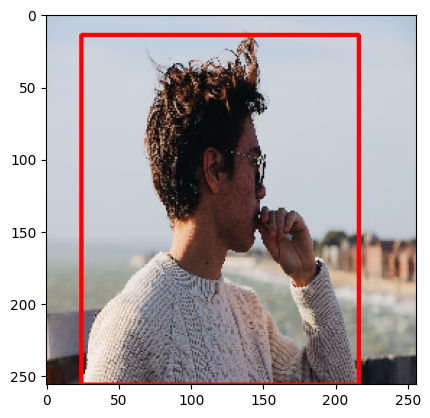

In [8]:
show_im(bboxes,np.random.randint(0,high=847))

In [9]:
def y_size(path):
    img = cv.imread(path)
    y,x = img.shape[:2]
    return y
def x_size(path):
    img = cv.imread(path)
    y,x = img.shape[:2]
    return x

Now, we are trying to add two columns to the dataframe that show heights and widths of the images. These columns will be used later.

In [10]:
bboxes.loc[:,'path'] = bboxes.loc[:,'name'].apply(lambda x: os.path.join(folder,'images',x))

In [11]:
bboxes['h'] = bboxes['path'].apply(lambda x : y_size(x))

bboxes['w'] = bboxes['path'].apply(lambda x : x_size(x))
bboxes.head()

,name,x1,y1,x2,y2,path,h,w
0,photo-1518926193355-384108491160.jpg,1745,467,2320,1728,/kaggle/input/images/photo-1518926193355-38410...,1728,2592
1,photo-1533781967626-30da4a7fc297.jpg,660,624,2102,3888,/kaggle/input/images/photo-1533781967626-30da4...,3888,2592
2,29320bb8.jpg,1159,366,1338,920,/kaggle/input/images/29320bb8.jpg,1049,2592
3,91JuTaUSKaMh2yjB1C4A_IMG_9284.jpg,545,491,929,1509,/kaggle/input/images/91JuTaUSKaMh2yjB1C4A_IMG_...,1728,2592
4,91JuTaUSKaMh2yjB1C4A_IMG_92842.jpg,1091,984,1858,3018,/kaggle/input/images/91JuTaUSKaMh2yjB1C4A_IMG_...,3456,5184


In [12]:
def rescale(x, orig, new=256):
    return int((x/orig)*new)

Here, we add 4 more columns with resized corner co-ordinates of bounding boxes for easier retrieving of data for drawing bounding boxes, and 4 columns that are needed (class number, midpoint_x, midpoint_y, height, and width) of bounding boxes, as fractions of total height and width of image. This format is needed for yolov8 training. 

In [13]:
# all of these values have to be scaled to range [0,1]


bboxes['new_x1'] = bboxes.apply(lambda x: rescale(x['x1'], x['w']), axis=1)

bboxes['new_y1'] = bboxes.apply(lambda x: rescale(x['y1'], x['h']), axis=1)

bboxes['new_x2'] = bboxes.apply(lambda x: rescale(x['x2'], x['w']), axis=1)

bboxes['new_y2'] = bboxes.apply(lambda x: rescale(x['y2'], x['h']), axis=1)

bboxes['x'] = bboxes.apply(lambda a: ((a['x2']+a['x1'])/(2*a['w'])), axis=1)

bboxes['y'] = bboxes.apply(lambda a: ((a['y2']+a['y1'])/(2*a['h'])), axis=1)

bboxes['h'] = bboxes.apply(lambda a: (a['y2']-a['y1'])/a['h'], axis=1)

bboxes['w'] = bboxes.apply(lambda a: (a['x2']-a['x1'])/a['w'], axis=1)

bboxes.head()

,name,x1,y1,x2,y2,path,h,w,new_x1,new_y1,new_x2,new_y2,x,y
0,photo-1518926193355-384108491160.jpg,1745,467,2320,1728,/kaggle/input/images/photo-1518926193355-38410...,0.729745,0.221836,172,69,229,256,0.784144,0.635127
1,photo-1533781967626-30da4a7fc297.jpg,660,624,2102,3888,/kaggle/input/images/photo-1533781967626-30da4...,0.839506,0.556327,65,41,207,256,0.532793,0.580247
2,29320bb8.jpg,1159,366,1338,920,/kaggle/input/images/29320bb8.jpg,0.528122,0.069059,114,89,132,224,0.481674,0.612965
3,91JuTaUSKaMh2yjB1C4A_IMG_9284.jpg,545,491,929,1509,/kaggle/input/images/91JuTaUSKaMh2yjB1C4A_IMG_...,0.589120,0.148148,53,72,91,223,0.284336,0.578704
4,91JuTaUSKaMh2yjB1C4A_IMG_92842.jpg,1091,984,1858,3018,/kaggle/input/images/91JuTaUSKaMh2yjB1C4A_IMG_...,0.588542,0.147955,53,72,91,223,0.284433,0.578993


In [14]:
def show_(df, n):
#     figure = plt.figure(figsize=(3,3), dpi=200)
    img = cv.imread(os.path.join(folder,'images',df.iloc[:,0][n]))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    y, x = img.shape[:2]
    x1 = df.loc[:,'new_x1'][n]
    y1 = df.loc[:,'new_y1'][n]
    x2 = df.loc[:,'new_x2'][n]
    y2 = df.loc[:,'new_y2'][n]
    
    img = cv.resize(img, (256,256))
    img = cv.rectangle(img,(x1, y1),(x2, y2), (160,0,220), 2)
    plt.imshow(img)

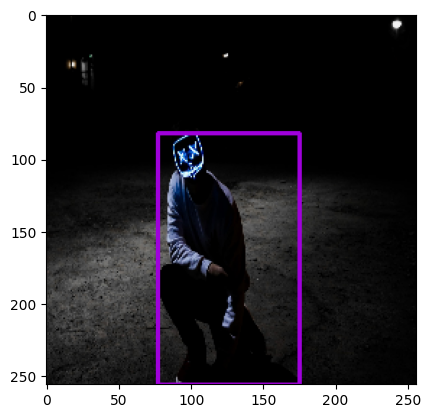

In [15]:
show_(bboxes, np.random.randint(low=0, high=847))

In [16]:
import gc
gc.collect()

6636

In [17]:
df = bboxes.copy().sample(n=847) #shuffling
df = df.reset_index(drop=True) #reindexing
df.head()

,name,x1,y1,x2,y2,path,h,w,new_x1,new_y1,new_x2,new_y2,x,y
0,photo-1474031317822-f51f48735ddd.jpg,493,327,1971,1728,/kaggle/input/images/photo-1474031317822-f51f4...,0.810764,0.570216,48,48,194,256,0.475309,0.594618
1,photo-1522649164000-8b1e51ec349e.jpg,730,513,1354,2385,/kaggle/input/images/photo-1522649164000-8b1e5...,0.731250,0.304688,91,51,169,238,0.508789,0.566016
2,photo-1500259783852-0ca9ce8a64dc.jpg,1546,1145,2157,2085,/kaggle/input/images/photo-1500259783852-0ca9c...,0.307190,0.249592,161,95,225,174,0.756332,0.527778
3,photo-1589127815612-fb3d4b42203c.jpg,0,229,2469,3628,/kaggle/input/images/photo-1589127815612-fb3d4...,0.936880,0.952546,0,16,243,256,0.476273,0.531560
4,photo-1520432348192-9cdc52574c87.jpg,896,792,1829,3616,/kaggle/input/images/photo-1520432348192-9cdc5...,0.726337,0.359954,88,52,180,238,0.525656,0.566872


In [18]:
df = df.drop(['x1', 'x2', 'y1','y2'], axis=1)
df.head()

,name,path,h,w,new_x1,new_y1,new_x2,new_y2,x,y
0,photo-1474031317822-f51f48735ddd.jpg,/kaggle/input/images/photo-1474031317822-f51f4...,0.810764,0.570216,48,48,194,256,0.475309,0.594618
1,photo-1522649164000-8b1e51ec349e.jpg,/kaggle/input/images/photo-1522649164000-8b1e5...,0.731250,0.304688,91,51,169,238,0.508789,0.566016
2,photo-1500259783852-0ca9ce8a64dc.jpg,/kaggle/input/images/photo-1500259783852-0ca9c...,0.307190,0.249592,161,95,225,174,0.756332,0.527778
3,photo-1589127815612-fb3d4b42203c.jpg,/kaggle/input/images/photo-1589127815612-fb3d4...,0.936880,0.952546,0,16,243,256,0.476273,0.531560
4,photo-1520432348192-9cdc52574c87.jpg,/kaggle/input/images/photo-1520432348192-9cdc5...,0.726337,0.359954,88,52,180,238,0.525656,0.566872


In [19]:
train = df.iloc[:int((847)*(0.7)),:]
test = df.iloc[int((847)*(0.7)):,:].reset_index(drop=True) #same as the train_test_split
print(train.shape, test.shape)

(592, 10) (255, 10)


In [20]:
train.head()

,name,path,h,w,new_x1,new_y1,new_x2,new_y2,x,y
0,photo-1474031317822-f51f48735ddd.jpg,/kaggle/input/images/photo-1474031317822-f51f4...,0.810764,0.570216,48,48,194,256,0.475309,0.594618
1,photo-1522649164000-8b1e51ec349e.jpg,/kaggle/input/images/photo-1522649164000-8b1e5...,0.731250,0.304688,91,51,169,238,0.508789,0.566016
2,photo-1500259783852-0ca9ce8a64dc.jpg,/kaggle/input/images/photo-1500259783852-0ca9c...,0.307190,0.249592,161,95,225,174,0.756332,0.527778
3,photo-1589127815612-fb3d4b42203c.jpg,/kaggle/input/images/photo-1589127815612-fb3d4...,0.936880,0.952546,0,16,243,256,0.476273,0.531560
4,photo-1520432348192-9cdc52574c87.jpg,/kaggle/input/images/photo-1520432348192-9cdc5...,0.726337,0.359954,88,52,180,238,0.525656,0.566872


In [21]:
test.head()

,name,path,h,w,new_x1,new_y1,new_x2,new_y2,x,y
0,photo-1542481776-2e5831c21f0d.jpg,/kaggle/input/images/photo-1542481776-2e5831c2...,0.338542,0.072531,126,112,145,199,0.530864,0.610243
1,photo-1586723276476-4f8edb2b77c6.jpg,/kaggle/input/images/photo-1586723276476-4f8ed...,0.977080,0.805556,0,5,206,256,0.402778,0.511460
2,photo-1574784618880-a1036d310e7c.jpg,/kaggle/input/images/photo-1574784618880-a1036...,0.890625,0.680556,38,28,212,256,0.489583,0.554688
3,photo-1541453269282-2cca4325771f.jpg,/kaggle/input/images/photo-1541453269282-2cca4...,0.202959,0.301396,104,160,181,212,0.558016,0.726761
4,photo-1534083264897-aeabfc7daf8a.jpg,/kaggle/input/images/photo-1534083264897-aeabf...,0.545139,0.510802,63,101,194,240,0.503472,0.668403


# Converting to required format
We need the coordinates of each bouning box to be inside unique text file named the same as the image.
The parent folder should have two sub-directories, test and train. Both of them have images and labels sub-directories.

In [22]:
if not os.path.exists('/kaggle/working/labels/train'):
    os.makedirs('/kaggle/working/labels/train')
if not os.path.exists('/kaggle/working/labels/test'):
    os.makedirs('/kaggle/working/labels/test')
if not os.path.exists('/kaggle/working/images/train'):
    os.makedirs('/kaggle/working/images/train')
if not os.path.exists('/kaggle/working/images/test'):
    os.makedirs('/kaggle/working/images/test')

In [23]:
import shutil
# this library is used to copy, paste, move files and folders

In [24]:
for index, k in train.iterrows():
    filename = '/kaggle/working/labels/train/{}.txt'.format(k['name'][:-4])
    s = "%d %s %s %s %s"
    c = 0
    x = k['x']
    y = k['y']
    w = k['w']
    h = k['h']
    t = (c, x, y, w, h)
    with open(filename, 'w') as f:
        l = (s%t)
        f.write(l)
    shutil.copyfile('/kaggle/input/images/{}'.format(k['name']), '/kaggle/working/images/train/{}'.format(k['name']))
    train.iloc[index, 1] = '/kaggle/working/images/train/{}'.format(k['name'])

In [25]:
for index, k in test.iterrows():
    filename = '/kaggle/working/labels/test/{}.txt'.format(k['name'][:-4])
    s = "%d %s %s %s %s"
    c = 0
    x = k['x']
    y = k['y']
    w = k['w']
    h = k['h']
    t = (c, x, y, w, h)
    with open(filename, 'w') as f:
        l = (s%t)
        f.write(l)
    shutil.copyfile('/kaggle/input/images/{}'.format(k['name']), '/kaggle/working/images/test/{}'.format(k['name']))
    test.iloc[index, 1] = '/kaggle/working/images/test/{}'.format(k['name'])

In [26]:
train.head()

,name,path,h,w,new_x1,new_y1,new_x2,new_y2,x,y
0,photo-1474031317822-f51f48735ddd.jpg,/kaggle/working/images/train/photo-14740313178...,0.810764,0.570216,48,48,194,256,0.475309,0.594618
1,photo-1522649164000-8b1e51ec349e.jpg,/kaggle/working/images/train/photo-15226491640...,0.731250,0.304688,91,51,169,238,0.508789,0.566016
2,photo-1500259783852-0ca9ce8a64dc.jpg,/kaggle/working/images/train/photo-15002597838...,0.307190,0.249592,161,95,225,174,0.756332,0.527778
3,photo-1589127815612-fb3d4b42203c.jpg,/kaggle/working/images/train/photo-15891278156...,0.936880,0.952546,0,16,243,256,0.476273,0.531560
4,photo-1520432348192-9cdc52574c87.jpg,/kaggle/working/images/train/photo-15204323481...,0.726337,0.359954,88,52,180,238,0.525656,0.566872


In [27]:
test.head()

,name,path,h,w,new_x1,new_y1,new_x2,new_y2,x,y
0,photo-1542481776-2e5831c21f0d.jpg,/kaggle/working/images/test/photo-1542481776-2...,0.338542,0.072531,126,112,145,199,0.530864,0.610243
1,photo-1586723276476-4f8edb2b77c6.jpg,/kaggle/working/images/test/photo-158672327647...,0.977080,0.805556,0,5,206,256,0.402778,0.511460
2,photo-1574784618880-a1036d310e7c.jpg,/kaggle/working/images/test/photo-157478461888...,0.890625,0.680556,38,28,212,256,0.489583,0.554688
3,photo-1541453269282-2cca4325771f.jpg,/kaggle/working/images/test/photo-154145326928...,0.202959,0.301396,104,160,181,212,0.558016,0.726761
4,photo-1534083264897-aeabfc7daf8a.jpg,/kaggle/working/images/test/photo-153408326489...,0.545139,0.510802,63,101,194,240,0.503472,0.668403


In [28]:
lists = os.listdir('/kaggle/working/images/test')
# lists
def addi(k,lists):
    an = []
    for p in lists:
        an.append(os.path.join(k,p))
    return an
lists

['photo-1468078809804-4c7b3e60a478.jpg',
 'photo-1518882300677-48cc76cc8463.jpg',
 'photo-1508312916837-f6a8aeb9278d.jpg',
 'photo-1462674332772-fc6f90da9774.jpg',
 'photo-1492681290082-e932832941e6.jpg',
 'photo-1469395013119-ca3b424d83e5.jpg',
 'photo-1520248033529-d05cd1981e6f.jpg',
 'photo-1500061982269-8126fe112dc0.jpg',
 'photo-1519076381129-b4234ae7e573.jpg',
 'photo-1476254737979-40c1226140e4.jpg',
 'photo-1520975708797-fd2543e902bf.jpg',
 'photo-1609043238954-c069d4e5a0e4.jpg',
 'photo-1610392533001-bccdab7d9234.jpg',
 'photo-1523154080482-faa42c0c5125.jpg',
 'photo-1579295560051-3df968edb036.jpg',
 'photo-1466916119434-d72cdf577c4d.jpg',
 'photo-1610780757769-d46802dc2675.jpg',
 'photo-1518712743-5fa6ec04832e.jpg',
 'photo-1555589182-9a54b861d138.jpg',
 'photo-1542481776-2e5831c21f0d.jpg',
 'photo-1489980478712-2ab535aa775f.jpg',
 'photo-1615506236937-446d39d6cbce.jpg',
 'photo-1530466951295-f13b9bceb117.jpg',
 'photo-1534429068323-d715c5a6d96b.jpg',
 'photo-1599566147214-ce4

In [29]:

lists = os.listdir('/kaggle/working/images/train')
# lists
lists = addi('/kaggle/working/images/train',lists)
lists

['/kaggle/working/images/train/photo-1523441762460-ec62c5a82a40.jpg',
 '/kaggle/working/images/train/photo-1518689016133-c812df02059a.jpg',
 '/kaggle/working/images/train/photo-1517265035603-faefa167335b.jpg',
 '/kaggle/working/images/train/photo-1542663992-7ccaf6d61ad5.jpg',
 '/kaggle/working/images/train/photo-1470138831303-3e77dd49163e.jpg',
 '/kaggle/working/images/train/photo-1585496661952-434a2b7b5375.jpg',
 '/kaggle/working/images/train/photo-1504899567410-7501a313cadd.jpg',
 '/kaggle/working/images/train/photo-1609043239075-b84f30707c63.jpg',
 '/kaggle/working/images/train/photo-1592465903416-385f1b0d2514.jpg',
 '/kaggle/working/images/train/photo-1601374670932-0f3c4e5b952e.jpg',
 '/kaggle/working/images/train/photo-1611885890372-c36429bfa50f.jpg',
 '/kaggle/working/images/train/photo-1453396450673-3fe83d2db2c4.jpg',
 '/kaggle/working/images/train/photo-1567002561236-cef3fb9aa301.jpg',
 '/kaggle/working/images/train/photo-1614970093356-5f6b7c3cfe96.jpg',
 '/kaggle/working/image

In [30]:
os.listdir('/kaggle/working/labels/train')

['photo-1522649164000-8b1e51ec349e.txt',
 'photo-1527534085786-f44cde0659a2.txt',
 'photo-1487528001669-63c47a53fd39.txt',
 'photo-1524054272861-f52657295c58.txt',
 'photo-1531503142345-91a2368273a2.txt',
 'photo-1612441611175-f101b02c930d.txt',
 'photo-1582917626755-57038b4388f4.txt',
 'photo-1541428166776-2d0445c35c1b.txt',
 'photo-1535713875002-d1d0cf377fde.txt',
 'photo-1589571894960-20bbe2828d0a.txt',
 'photo-1496302662116-35cc4f36df92.txt',
 'photo-1521443331827-88ee11ea2706.txt',
 'photo-1534790741270-1ecaaee38a98.txt',
 'photo-1533520268320-002d95fe2145.txt',
 'photo-1504346466600-714572c4b726.txt',
 'photo-1533850595620-7b1711221751.txt',
 'photo-1519624168461-3f1df67564cc.txt',
 'photo-1494675006433-9e9428eba6c7.txt',
 'photo-1558515543-7b63156d1f70.txt',
 'photo-1542397656-5dfd6adec561.txt',
 'photo-1617859822391-9c4bc92ff4f4.txt',
 'photo-1543264409-e5b66373d4d8.txt',
 'photo-1597528951916-2088c8f22757.txt',
 'photo-1541945871441-1004baea6f8e.txt',
 'photo-1616541303066-b50

# Making a yaml file to feed yolov8

In [31]:
!pip install ultralytics --upgrade
from ultralytics import YOLO
!pip install wandb
import wandb
wandb.login()

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 878.7/878.7 kB 16.6 MB/s eta 0:00:00a 0:00:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [32]:
wandb.init(project="explo")

wandb: Currently logged in as: ikshwakgunnoju (ikshwakgunnoju-indian-institute-of-technology-bhu-varanasi). Use `wandb login --relogin` to force relogin


In [33]:
filename = '/kaggle/working/data.yaml'
with open(filename, 'w') as f:
    s = f'''
    
    train: /kaggle/working/images/train
    val: /kaggle/working/images/test
    test: /kaggle/working/images/test
    nc: 1
    names: ['person']'''
    f.write(s)

In [34]:
os.path.isfile('/kaggle/working/data.yaml')

True

In [35]:
import yaml
with open('/kaggle/working/data.yaml', 'r') as f:
    k = yaml.safe_load(f)
k

{'train': '/kaggle/working/images/train',
 'val': '/kaggle/working/images/test',
 'test': '/kaggle/working/images/test',
 'nc': 1,
 'names': ['person']}

# Training
Getting the pre-trained model and training it

In [36]:
model1 = YOLO('yolov8n.pt')
model2 = YOLO('yolov8n.yaml')

100%|██████████| 6.25M/6.25M [00:00<00:00, 72.1MB/s]


In [37]:
t = lists[:20]

In [38]:
def sh(results, i):
    plot = results[i].plot()
    plot = cv.cvtColor(plot, cv.COLOR_BGR2RGB)
    plt.imshow(plot)

In [39]:
results1 = model1.predict(t)


0: 640x640 1 person, 1 chair, 5.2ms
1: 640x640 1 person, 3 chairs, 2 potted plants, 1 vase, 5.2ms
2: 640x640 1 person, 1 backpack, 5.2ms
3: 640x640 1 person, 5.2ms
4: 640x640 1 person, 5.2ms
5: 640x640 1 person, 5.2ms
6: 640x640 1 person, 5.2ms
7: 640x640 1 person, 5.2ms
8: 640x640 1 person, 5.2ms
9: 640x640 1 person, 1 bed, 1 cell phone, 5.2ms
10: 640x640 1 person, 5.2ms
11: 640x640 (no detections), 5.2ms
12: 640x640 14 persons, 1 motorcycle, 1 truck, 1 traffic light, 5.2ms
13: 640x640 1 person, 5.2ms
14: 640x640 1 person, 5.2ms
15: 640x640 1 person, 5.2ms
16: 640x640 1 person, 5.2ms
17: 640x640 2 persons, 5.2ms
18: 640x640 1 person, 5.2ms
19: 640x640 1 person, 5.2ms
Speed: 2.7ms preprocess, 5.2ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)


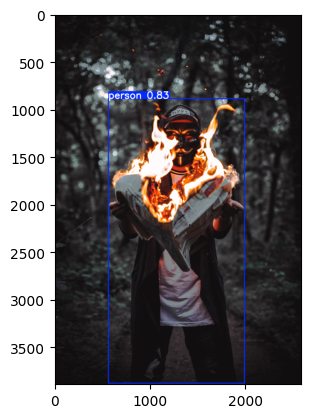

In [40]:
sh(results1, np.random.randint(low=0, high=len(t)))

In [41]:
history1 = model1.train(
    data='/kaggle/working/data.yaml',
    epochs=200,
    optimizer='auto',
    imgsz=(256),
    batch=-1,
    single_cls=True,
    pretrained=True,
    cache=True
)

Ultralytics 8.3.25 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=200, time=None, patience=100, batch=-1, imgsz=256, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, l

100%|██████████| 755k/755k [00:00<00:00, 14.0MB/s]
2024-10-31 12:17:37,046	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-31 12:17:37,555	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 65.6MB/s]


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=256 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.74G total, 0.79G reserved, 0.07G allocated, 13.88G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011043       1.311         0.111         39.22         119.1        (1, 3, 256, 256)                    list
     3011043       2.622         0.128         19.67         48.48        (2, 3, 256, 256)                    list
     3011043       5.244         0.170         21.55         49.97        (4, 3, 256, 256)                    list
     3011043       10.49         0.237         24.41         51.16        (8, 3, 256, 256)                    list
     3011043       20.98         0.367         25.25         104.3       (16, 3, 256, 256)                    list
AutoBatch: Using batch-size 483 for CUDA:0 9.18G/14.74G (62%) ✅


train: Scanning /kaggle/working/labels/train... 592 images, 0 backgrounds, 0 corrupt: 100%|██████████| 592/592 [00:00<00:00, 1123.57it/s]

train: New cache created: /kaggle/working/labels/train.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 592/592 [00:09<00:00, 64.73it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/labels/test... 255 images, 0 backgrounds, 0 corrupt: 100%|██████████| 255/255 [00:00<00:00, 1069.11it/s]

val: New cache created: /kaggle/working/labels/test.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 255/255 [00:04<00:00, 55.05it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0037734375), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      9.64G      2.923      3.284      2.506        262        256: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

                   all        255        255    0.00323      0.784     0.0728      0.024



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      9.61G      2.822      3.274      2.457        280        256: 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all        255        255    0.00303      0.749     0.0785     0.0197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      9.61G      2.847      3.258      2.481        269        256: 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all        255        255    0.00353      0.816      0.107     0.0305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      9.63G      2.884      3.283       2.51        278        256: 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all        255        255    0.00393      0.812      0.148     0.0517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      9.64G       2.78      3.163       2.43        262        256: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all        255        255    0.00417      0.827      0.179     0.0641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      9.64G      2.656      2.937      2.301        281        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all        255        255    0.00391      0.808      0.234     0.0897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      9.64G      2.462      2.533      2.155        270        256: 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all        255        255    0.00368      0.808      0.295      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      9.64G      2.202      2.151      2.002        270        256: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all        255        255      0.311      0.498      0.352      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      9.64G      1.982      1.801      1.884        282        256: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all        255        255      0.765      0.115      0.343      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      9.64G        1.8      1.581      1.752        278        256: 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all        255        255      0.817      0.157      0.353      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      9.64G      1.719      1.522      1.719        279        256: 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all        255        255      0.824      0.212      0.373      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      9.64G      1.578      1.417      1.607        259        256: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all        255        255      0.792      0.278       0.38      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      9.64G      1.508      1.319      1.574        283        256: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all        255        255      0.676      0.263      0.354      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      9.64G      1.379      1.227      1.493        257        256: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all        255        255      0.622      0.247      0.342      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      9.64G       1.38      1.255      1.477        282        256: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all        255        255      0.664      0.302      0.386      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      9.64G      1.251      1.114      1.407        270        256: 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all        255        255      0.681      0.343      0.442      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      9.64G      1.249      1.114      1.397        294        256: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all        255        255      0.741      0.369       0.47      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      9.64G      1.189      1.049      1.345        278        256: 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all        255        255      0.758      0.337      0.444      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      9.64G      1.173      1.066       1.35        254        256: 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all        255        255      0.711      0.298       0.41      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      9.64G      1.132      1.021      1.318        258        256: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all        255        255      0.718      0.349      0.442      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      9.64G      1.063     0.9551      1.289        252        256: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all        255        255      0.779       0.43      0.521      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      9.64G      1.105      0.966      1.306        265        256: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all        255        255      0.845       0.51      0.622      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      9.64G      1.027     0.9126      1.255        286        256: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all        255        255      0.928      0.514      0.664      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      9.64G      1.049     0.9336      1.261        287        256: 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all        255        255      0.784      0.612      0.698      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      9.64G     0.9752     0.8751      1.228        271        256: 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all        255        255      0.827      0.659      0.741       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      9.64G     0.9437     0.8514      1.201        260        256: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all        255        255      0.844      0.681      0.772      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      9.64G     0.9525     0.8633      1.223        259        256: 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all        255        255      0.859      0.678      0.771      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      9.64G     0.9613     0.8421      1.218        290        256: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all        255        255      0.848      0.678      0.764       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      9.64G     0.9262     0.8503      1.209        260        256: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all        255        255      0.836      0.698      0.779      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      9.64G     0.9136     0.7973       1.18        277        256: 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all        255        255      0.834      0.741      0.802      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      9.64G     0.8685     0.7667      1.166        265        256: 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all        255        255      0.837      0.784       0.83      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      9.64G     0.8964     0.7812      1.185        268        256: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all        255        255      0.874      0.792      0.863      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      9.64G     0.9296     0.7944       1.19        290        256: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all        255        255      0.903      0.803      0.879      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      9.64G     0.8598     0.7499      1.164        273        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all        255        255      0.885      0.845      0.895      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      9.64G     0.8558     0.7311      1.166        255        256: 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all        255        255      0.905      0.851      0.905      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      9.64G      0.892     0.7507      1.166        273        256: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all        255        255       0.91      0.847      0.911      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      9.64G     0.8478     0.7106      1.153        277        256: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all        255        255      0.878      0.874      0.914      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      9.64G     0.8336     0.7207      1.154        251        256: 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all        255        255      0.941       0.82      0.914      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      9.64G     0.8128     0.6899      1.129        275        256: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all        255        255      0.923      0.867      0.921       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      9.64G     0.8747     0.7192      1.162        258        256: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all        255        255      0.906      0.886      0.928      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      9.64G     0.8367     0.6957      1.138        263        256: 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all        255        255      0.909      0.897       0.93      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      9.64G     0.8221     0.6933      1.126        289        256: 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all        255        255      0.926      0.889      0.934      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      9.64G     0.8106     0.6876      1.122        287        256: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all        255        255      0.928      0.902      0.946      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      9.64G     0.8181     0.6711      1.131        273        256: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all        255        255      0.898      0.933      0.947      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      9.64G     0.8591     0.7202      1.139        290        256: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all        255        255      0.905      0.918      0.942      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      9.64G     0.8016     0.6825      1.127        267        256: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all        255        255      0.929      0.874       0.93        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      9.64G     0.8001     0.6648      1.115        282        256: 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all        255        255      0.856      0.884      0.905      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      9.64G      0.783     0.6978      1.114        272        256: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all        255        255      0.879      0.871      0.924      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      9.64G     0.7979     0.6842      1.118        270        256: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all        255        255      0.889      0.902      0.932      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      9.64G     0.7976     0.6651      1.123        275        256: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all        255        255      0.893      0.886      0.931      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      9.64G     0.7925     0.6581      1.101        275        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all        255        255      0.891      0.902      0.929      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      9.64G     0.8061     0.6479      1.125        272        256: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all        255        255      0.889      0.914      0.933      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      9.64G     0.7685     0.6364      1.108        258        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all        255        255       0.89      0.922      0.934      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      9.64G     0.7659     0.6264        1.1        260        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all        255        255      0.934      0.914      0.947      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      9.64G     0.7865      0.628      1.107        282        256: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all        255        255      0.915       0.91      0.948      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      9.64G     0.7427     0.6246      1.094        277        256: 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all        255        255      0.921      0.902      0.939      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      9.64G     0.7706     0.6446      1.094        264        256: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all        255        255      0.955      0.878      0.937      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      9.64G     0.7595     0.6195      1.104        265        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

                   all        255        255      0.943      0.863      0.925      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      9.64G     0.7875     0.6333      1.094        284        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all        255        255      0.941      0.867      0.922      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      9.64G     0.7432     0.6221      1.097        264        256: 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all        255        255      0.932      0.911      0.946      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      9.64G     0.7514     0.6076      1.084        283        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all        255        255      0.963      0.898      0.956      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      9.64G     0.7502     0.6176      1.082        268        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all        255        255      0.927      0.902      0.939      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      9.64G     0.7229      0.597       1.07        265        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all        255        255      0.952      0.924      0.946      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      9.64G     0.7717     0.6195      1.101        236        256: 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all        255        255      0.942      0.918      0.942      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      9.64G     0.7492     0.6135      1.093        278        256: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all        255        255      0.932      0.921      0.946      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      9.64G     0.7223     0.5924      1.072        274        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all        255        255      0.937       0.91      0.945      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      9.64G     0.7151     0.5831      1.072        269        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all        255        255      0.915      0.922      0.946      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      9.64G     0.7188     0.5735      1.064        268        256: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all        255        255      0.946      0.897      0.945      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      9.64G     0.7189     0.5761      1.063        265        256: 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all        255        255       0.95      0.901      0.955       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      9.64G     0.7277     0.5861      1.088        286        256: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all        255        255      0.949      0.914      0.955      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      9.64G     0.7021     0.5797      1.062        262        256: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all        255        255      0.966       0.89       0.95       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      9.64G     0.7054     0.5914      1.067        267        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all        255        255      0.954      0.896      0.954      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      9.64G     0.6989      0.575      1.066        267        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

                   all        255        255      0.942      0.922      0.955      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      9.64G     0.6897     0.5823      1.072        276        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all        255        255      0.937      0.886      0.936      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      9.64G     0.6735     0.5658      1.065        259        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all        255        255      0.897       0.91      0.943       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      9.64G     0.6946     0.5582      1.066        265        256: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all        255        255      0.928      0.915      0.949      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      9.64G     0.7052     0.5502      1.055        287        256: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all        255        255      0.932      0.902      0.938      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      9.64G     0.6928     0.5478      1.037        263        256: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all        255        255      0.924      0.914      0.944      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      9.64G     0.7031      0.561      1.068        254        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all        255        255      0.949      0.902      0.938      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      9.64G     0.6605     0.5273      1.026        281        256: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all        255        255      0.945      0.898      0.937      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      9.64G     0.7004     0.5473      1.063        268        256: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all        255        255      0.941      0.898      0.934      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      9.64G      0.647     0.5159      1.036        260        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all        255        255       0.93      0.918      0.944      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      9.64G     0.6989     0.5346       1.07        252        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all        255        255      0.949      0.918      0.952      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      9.64G     0.7025     0.5219      1.056        279        256: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all        255        255      0.911      0.922      0.941      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      9.64G     0.7001      0.547      1.075        260        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all        255        255       0.92      0.922      0.942      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      9.64G      0.703     0.5637      1.057        255        256: 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all        255        255      0.928      0.922      0.947      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      9.64G     0.6632     0.5336       1.04        290        256: 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all        255        255      0.929      0.923      0.952      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      9.64G     0.6768     0.5324      1.038        268        256: 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all        255        255      0.953      0.929      0.951      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      9.64G     0.6841     0.5485      1.052        274        256: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all        255        255      0.959      0.921      0.949      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      9.64G     0.6927     0.5282      1.046        270        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all        255        255      0.958       0.91      0.946      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      9.64G     0.6631      0.523      1.044        281        256: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all        255        255      0.956      0.914      0.955      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      9.64G     0.6603     0.5129      1.035        268        256: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all        255        255      0.946      0.914      0.949      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      9.64G      0.657     0.4979      1.033        282        256: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all        255        255      0.948      0.902       0.95      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      9.64G     0.6496     0.5089      1.042        251        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all        255        255      0.947      0.912      0.949      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      9.64G     0.6695     0.5254      1.044        281        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all        255        255      0.967       0.92      0.959      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      9.64G     0.7016     0.5323      1.058        257        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all        255        255      0.929      0.924      0.959      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      9.64G     0.6978       0.54      1.072        263        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all        255        255      0.911      0.919      0.961      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      9.64G     0.6574      0.505      1.057        273        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all        255        255      0.954      0.892      0.955      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      9.64G     0.6399     0.4992      1.033        269        256: 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all        255        255      0.959      0.918      0.959      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      9.64G     0.6381     0.5052      1.031        263        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all        255        255      0.948      0.927      0.957      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      9.64G     0.6495     0.5113       1.03        250        256: 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all        255        255      0.944      0.919      0.951      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      9.64G     0.6116     0.4896      1.003        276        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all        255        255      0.948      0.927      0.957      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      9.64G     0.6022     0.4692      1.007        280        256: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all        255        255      0.946      0.918       0.96      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      9.64G     0.6282     0.4963      1.037        268        256: 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all        255        255      0.958      0.903      0.958      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      9.64G      0.634      0.487      1.014        260        256: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all        255        255      0.972      0.894      0.955      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      9.64G     0.5903      0.457      1.008        263        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all        255        255      0.959      0.875      0.943       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      9.64G     0.6689     0.4865      1.043        261        256: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all        255        255      0.934      0.922      0.959      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      9.64G     0.6451     0.4755      1.012        259        256: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all        255        255      0.945      0.935      0.963      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      9.64G     0.6231     0.4909      1.024        249        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all        255        255      0.935      0.933      0.961      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      9.64G     0.6475     0.4895      1.033        271        256: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all        255        255      0.948       0.91      0.955      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      9.64G     0.6335     0.4876      1.027        246        256: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all        255        255      0.964      0.929      0.959      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      9.64G     0.6367     0.4858      1.028        262        256: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all        255        255      0.929      0.937      0.956      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      9.64G     0.6146     0.4829      1.019        274        256: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all        255        255      0.951      0.915      0.946      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      9.64G     0.6056     0.4735      1.019        282        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all        255        255      0.934      0.918      0.947      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      9.64G     0.6392     0.4682      1.021        262        256: 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all        255        255      0.948       0.92      0.954      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      9.64G     0.6189     0.4789      1.007        278        256: 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

                   all        255        255      0.938      0.922      0.949      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      9.64G     0.6178     0.4582      1.024        265        256: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all        255        255      0.955      0.918      0.957      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      9.64G     0.6193     0.4759      1.031        266        256: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all        255        255      0.944      0.933      0.956       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      9.64G     0.6301     0.4782      1.026        281        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all        255        255      0.948      0.929      0.955      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      9.64G     0.6113     0.4652       1.02        279        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all        255        255      0.959      0.902       0.95      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      9.64G     0.6186     0.4947       1.03        263        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all        255        255       0.95       0.91      0.948      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      9.64G     0.5892      0.454      1.008        258        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all        255        255       0.95      0.902      0.949      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      9.64G     0.6382     0.4879       1.02        284        256: 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all        255        255       0.94      0.929      0.958      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      9.64G     0.6156      0.464      1.038        265        256: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all        255        255      0.969      0.925      0.965      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      9.64G     0.6138     0.4597      1.024        253        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all        255        255      0.974      0.929      0.968      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      9.64G     0.6171     0.4614      1.015        265        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all        255        255      0.963      0.926      0.957      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      9.64G     0.5986     0.4428      1.002        276        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all        255        255      0.959      0.922      0.959      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      9.64G     0.5843     0.4473     0.9886        277        256: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all        255        255       0.94      0.937      0.958      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      9.64G     0.5987     0.4525      1.005        269        256: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all        255        255      0.951      0.898      0.952      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      9.64G     0.5898     0.4559      1.007        272        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all        255        255       0.93       0.91      0.943      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      9.64G     0.5813     0.4477      1.009        251        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all        255        255      0.922      0.931      0.949      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      9.64G     0.6035     0.4558      1.008        268        256: 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all        255        255      0.922      0.927      0.947      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      9.64G     0.5973     0.4643     0.9995        296        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all        255        255      0.935      0.914      0.947      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      9.64G     0.5967       0.45     0.9997        266        256: 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all        255        255      0.937      0.918      0.952      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      9.64G     0.5933     0.4477      1.004        273        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all        255        255      0.922       0.93      0.956      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      9.64G     0.5978     0.4567      1.001        302        256: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all        255        255      0.942      0.899      0.951      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      9.64G     0.6393     0.4711      1.031        264        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all        255        255      0.938       0.91      0.946       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      9.64G      0.598     0.4436      1.001        277        256: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all        255        255      0.941      0.933      0.955      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      9.64G     0.6046     0.4579      1.011        256        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all        255        255      0.955      0.925      0.958      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      9.64G      0.587     0.4512      1.007        254        256: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all        255        255      0.959      0.925      0.959      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      9.64G     0.5708     0.4463     0.9998        261        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all        255        255      0.955      0.922      0.955      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      9.64G     0.5611     0.4418      0.996        256        256: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all        255        255      0.958      0.918      0.958      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      9.64G     0.5847     0.4356      1.012        260        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all        255        255      0.971      0.908      0.955      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      9.64G      0.599     0.4435      1.005        273        256: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all        255        255      0.969       0.91      0.956      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      9.64G     0.5771     0.4421          1        246        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all        255        255      0.937      0.941      0.956      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      9.64G     0.5745     0.4255     0.9983        272        256: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all        255        255      0.973      0.898      0.958      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      9.64G     0.5719     0.4226      1.001        273        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all        255        255      0.948      0.914      0.961      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      9.64G     0.5947     0.4252          1        266        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all        255        255      0.951      0.916       0.96      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      9.64G     0.5706     0.4236      1.006        254        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all        255        255      0.946      0.922       0.96      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      9.64G     0.5579     0.4291     0.9903        288        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all        255        255      0.966      0.905      0.958      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      9.64G      0.582     0.4298     0.9976        289        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all        255        255      0.954      0.914      0.958      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      9.64G     0.5575     0.4237     0.9926        277        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all        255        255      0.951      0.918      0.955      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      9.64G     0.5468      0.421     0.9778        269        256: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all        255        255      0.939      0.913      0.948       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      9.64G     0.5726     0.4214      1.003        264        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all        255        255      0.934      0.914      0.947       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      9.64G     0.5437     0.4092     0.9914        273        256: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all        255        255      0.935      0.914      0.948      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      9.64G     0.5586     0.4187     0.9937        258        256: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all        255        255      0.935      0.914      0.953       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      9.64G     0.5793     0.4389     0.9865        273        256: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all        255        255       0.94      0.923      0.955      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      9.64G     0.5415     0.4114     0.9878        279        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all        255        255      0.965      0.902      0.953      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      9.64G     0.5555     0.4213     0.9916        287        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all        255        255      0.948       0.91      0.946      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      9.64G     0.5544     0.4024     0.9769        269        256: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all        255        255      0.946      0.906      0.939      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      9.64G     0.5644     0.4109     0.9889        281        256: 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all        255        255      0.944      0.898      0.938      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      9.64G      0.534     0.4171     0.9953        283        256: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all        255        255      0.958       0.89      0.945      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      9.64G     0.5601     0.4193      0.993        300        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all        255        255      0.946      0.891       0.94       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      9.64G      0.545     0.4043     0.9849        271        256: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all        255        255       0.94       0.91      0.947      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      9.64G     0.5618     0.4106     0.9812        261        256: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all        255        255      0.955      0.898      0.949      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      9.64G     0.5487     0.4121      0.986        282        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all        255        255      0.936      0.919      0.952      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      9.64G     0.5211     0.4152      0.978        269        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all        255        255      0.939      0.929      0.955      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      9.64G     0.5554     0.4192     0.9971        279        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all        255        255      0.936      0.925      0.952      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      9.64G     0.5515     0.4083     0.9922        275        256: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all        255        255      0.939      0.918      0.951      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      9.64G     0.5436      0.403     0.9824        281        256: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all        255        255       0.95      0.906      0.951      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      9.64G     0.5374     0.4027      0.986        290        256: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all        255        255      0.953      0.902      0.951      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      9.64G     0.5317     0.4049     0.9811        255        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all        255        255      0.963       0.89      0.949      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      9.64G     0.5347     0.3871      0.979        288        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all        255        255      0.968      0.886       0.95      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      9.64G     0.5589     0.3986     0.9881        255        256: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all        255        255       0.97      0.901      0.954      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      9.64G     0.5278     0.3898     0.9847        271        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all        255        255      0.975      0.908      0.959      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      9.64G     0.5352      0.392     0.9836        286        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all        255        255      0.978       0.91       0.96      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      9.64G     0.5172     0.3806     0.9863        262        256: 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all        255        255      0.977       0.91      0.961      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      9.64G     0.5358     0.3997     0.9933        277        256: 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all        255        255      0.973      0.914      0.963      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      9.64G      0.549     0.3985      0.994        273        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all        255        255      0.964      0.925      0.964      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      9.64G     0.5254     0.3923     0.9831        246        256: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all        255        255      0.967       0.92       0.96      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      9.64G     0.5415     0.3931     0.9837        285        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all        255        255      0.961      0.918       0.96       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      9.64G     0.5481     0.3987      1.005        277        256: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all        255        255      0.948      0.926      0.961      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      9.64G     0.5119     0.3919     0.9655        268        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all        255        255      0.942      0.937      0.958      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      9.64G     0.5531     0.4056      0.987        279        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all        255        255      0.952      0.928      0.962      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      9.64G     0.5255     0.3903     0.9888        255        256: 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all        255        255      0.949      0.925      0.961      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      9.64G     0.5291     0.3895     0.9699        268        256: 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all        255        255      0.948      0.933      0.955      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      9.64G     0.5543      0.392      1.005        255        256: 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all        255        255      0.959      0.921      0.954      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      9.64G     0.5266     0.3928     0.9783        273        256: 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all        255        255      0.953      0.918      0.954      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      9.64G      0.531     0.4003     0.9755        278        256: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all        255        255      0.936      0.925      0.952      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      9.64G     0.5005     0.3728      0.969        250        256: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all        255        255      0.944      0.929      0.955      0.777


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      9.64G     0.4405     0.5492     0.8742        109        256: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all        255        255      0.948      0.927      0.955      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      9.64G     0.4323     0.4609     0.8622        109        256: 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all        255        255      0.949      0.925      0.954      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      9.64G     0.4043     0.4071      0.863        109        256: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all        255        255      0.953      0.922      0.951      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      9.64G     0.4145     0.3883     0.8524        109        256: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all        255        255      0.954      0.918      0.944      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      9.64G     0.3795      0.317     0.8554        109        256: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all        255        255      0.955      0.922       0.95       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      9.64G     0.3968     0.3195     0.8623        109        256: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all        255        255      0.949      0.925       0.95      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      9.64G      0.374     0.3121     0.8667        109        256: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all        255        255      0.963      0.918       0.95      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      9.64G     0.3675     0.3083     0.8457        109        256: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all        255        255      0.959      0.929      0.958      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      9.64G     0.3673     0.2864     0.8503        109        256: 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all        255        255      0.959      0.924      0.955      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      9.64G     0.3738     0.2812     0.8407        109        256: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all        255        255      0.947      0.933      0.955      0.758



200 epochs completed in 0.149 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.25 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


                   all        255        255      0.964      0.929      0.959      0.785
Speed: 0.0ms preprocess, 0.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train


In [42]:
model1.model.names

{0: 'person'}


0: 256x256 1 person, 2.3ms
1: 256x256 1 person, 1 chair, 1 potted plant, 1 dining table, 2.3ms
2: 256x256 1 person, 2.3ms
3: 256x256 1 person, 2.3ms
4: 256x256 1 person, 2.3ms
5: 256x256 (no detections), 2.3ms
6: 256x256 1 person, 2.3ms
7: 256x256 1 person, 1 tennis racket, 2.3ms
8: 256x256 1 person, 2.3ms
9: 256x256 1 person, 1 bed, 2.3ms
10: 256x256 1 person, 2.3ms
11: 256x256 1 person, 2.3ms
12: 256x256 6 persons, 2.3ms
13: 256x256 1 person, 2.3ms
14: 256x256 1 person, 2.3ms
15: 256x256 2 persons, 1 kite, 2.3ms
16: 256x256 1 person, 2.3ms
17: 256x256 2 persons, 2.3ms
18: 256x256 1 person, 2.3ms
19: 256x256 1 person, 2.3ms
Speed: 0.6ms preprocess, 2.3ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


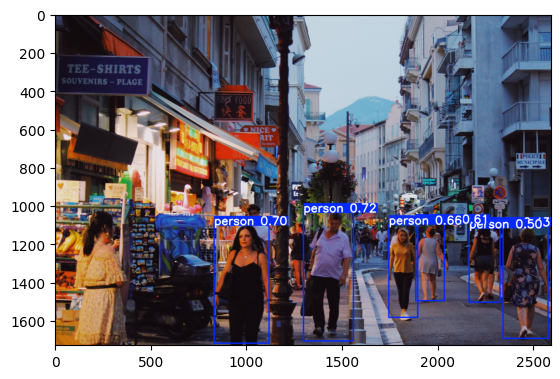

In [43]:
results1 = model1.predict(t)

sh(results1, np.random.randint(low=0, high=len(t)))

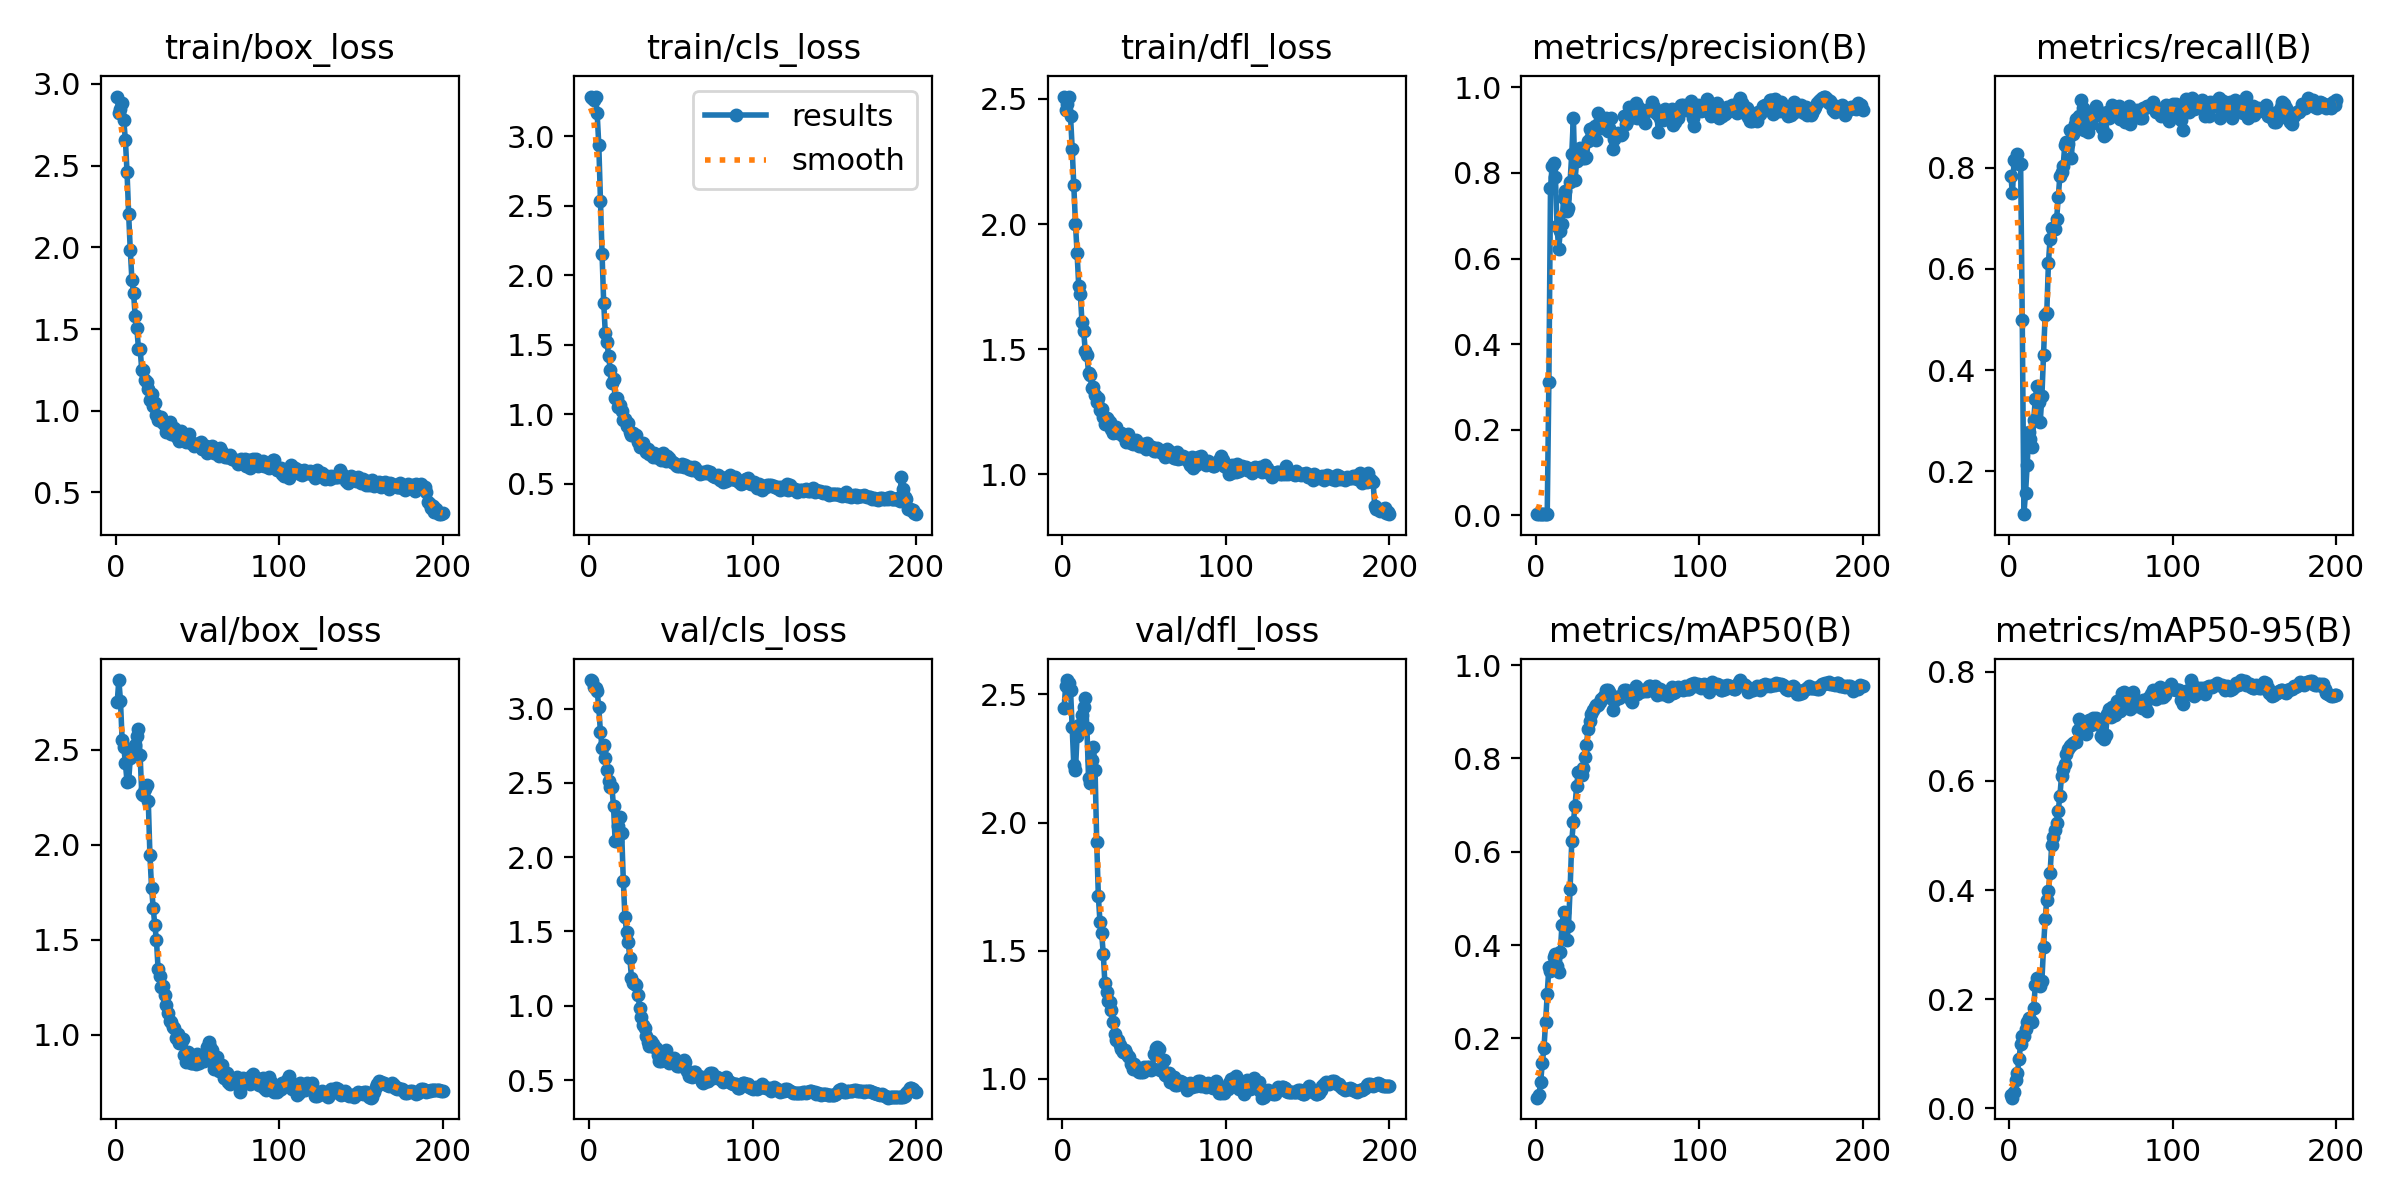

In [44]:
from IPython.display import Image

Image(filename='/kaggle/working/runs/detect/train/results.png', width=1100, height=550)

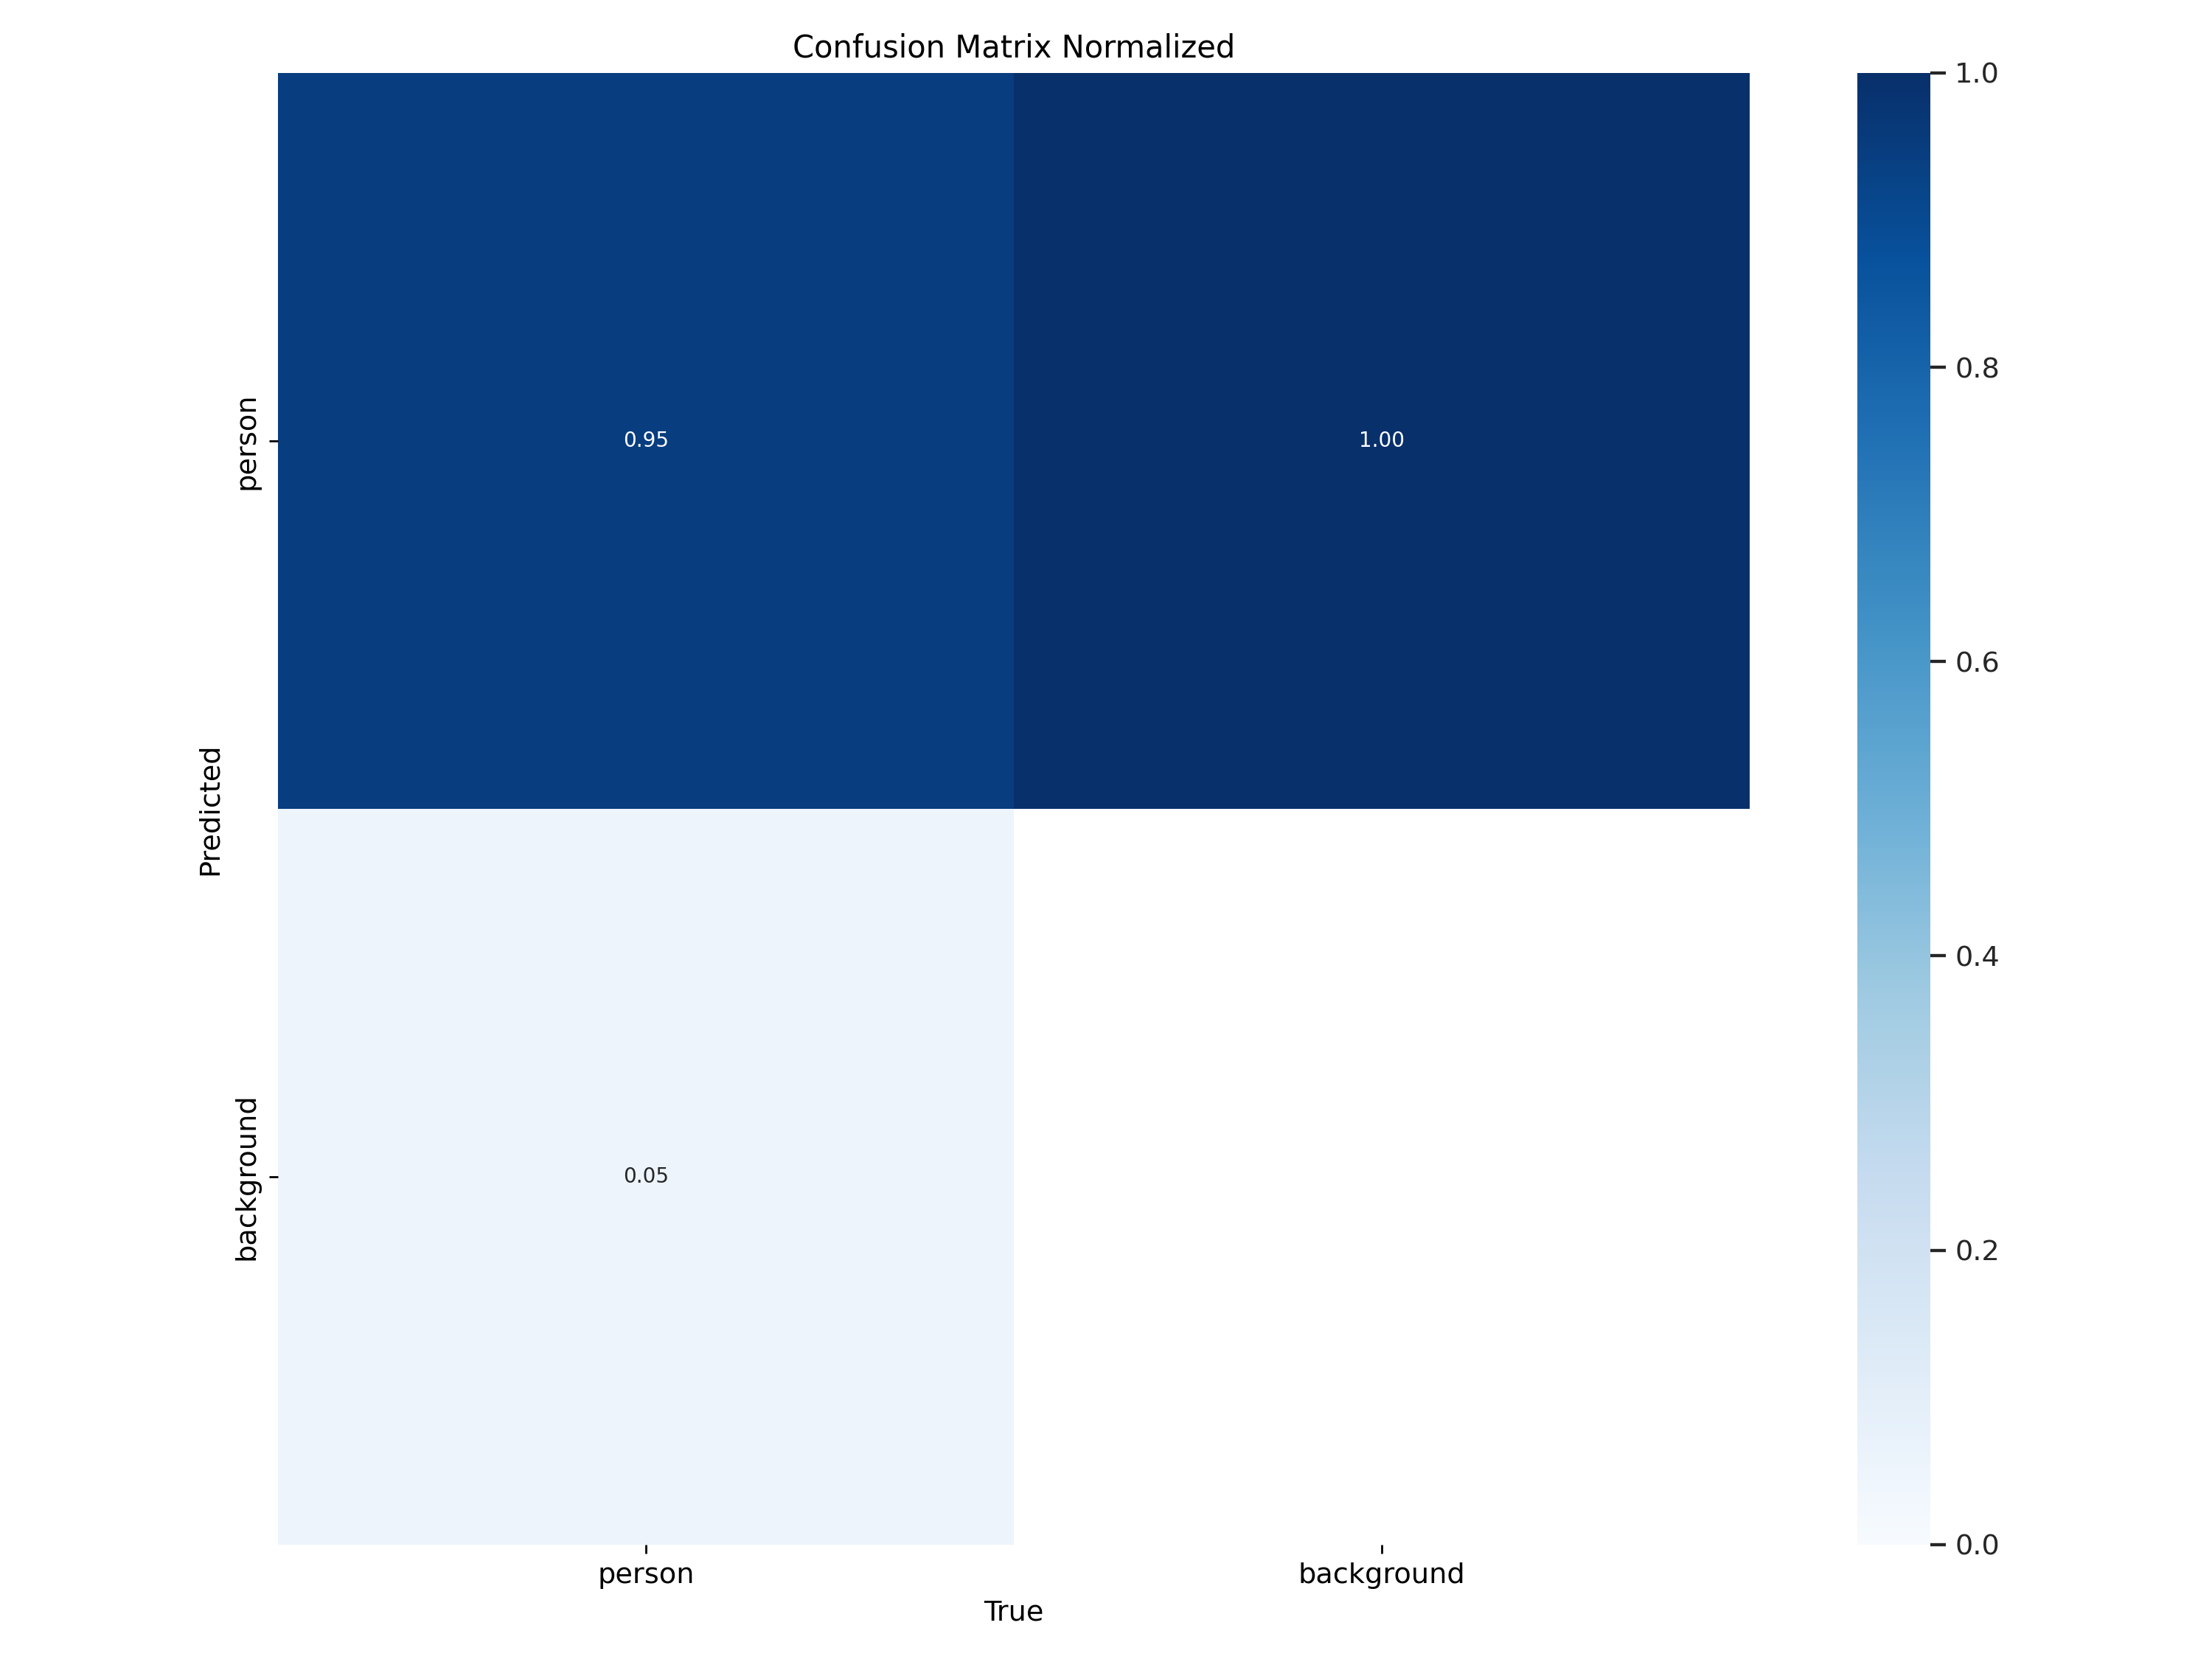

In [45]:
Image(filename='/kaggle/working/runs/detect/train/confusion_matrix_normalized.png', width=1100, height=550)

In [46]:
history2 = model2.train(
    data='/kaggle/working/data.yaml',
    epochs=200,
    optimizer='auto',
    imgsz=(256),
    batch=-1,
    single_cls=True,
    pretrained=False,
    cache=True
)

Ultralytics 8.3.25 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/kaggle/working/data.yaml, epochs=200, time=None, patience=100, batch=-1, imgsz=256, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

train: Scanning /kaggle/working/labels/train.cache... 592 images, 0 backgrounds, 0 corrupt: 100%|██████████| 592/592 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 592/592 [00:09<00:00, 61.75it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/labels/test.cache... 255 images, 0 backgrounds, 0 corrupt: 100%|██████████| 255/255 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 255/255 [00:04<00:00, 63.63it/s] 


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200     0.757G      3.382      3.485      4.174         37        256: 100%|██████████| 37/37 [00:03<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.34it/s]

                   all        255        255     0.0109      0.576     0.0647     0.0216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200     0.734G      3.307      2.835      3.798         47        256: 100%|██████████| 37/37 [00:03<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.78it/s]

                   all        255        255    0.00964      0.596     0.0601     0.0245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200     0.736G      3.132      2.581      3.401         41        256: 100%|██████████| 37/37 [00:03<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.69it/s]

                   all        255        255     0.0202     0.0706     0.0114     0.0041



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200     0.734G      2.951      2.507      3.208         46        256: 100%|██████████| 37/37 [00:02<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.40it/s]

                   all        255        255     0.0577      0.282     0.0343     0.0129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200     0.736G      2.703      2.392      3.057         49        256: 100%|██████████| 37/37 [00:03<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.47it/s]

                   all        255        255      0.121      0.247     0.0839     0.0293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200     0.736G      2.499      2.238      2.876         45        256: 100%|██████████| 37/37 [00:03<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.52it/s]

                   all        255        255      0.193      0.243      0.119     0.0435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200     0.736G      2.348      2.161      2.749         43        256: 100%|██████████| 37/37 [00:03<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.29it/s]

                   all        255        255      0.166      0.463      0.144     0.0446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200     0.736G      2.168      2.033      2.622         46        256: 100%|██████████| 37/37 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.40it/s]

                   all        255        255       0.26      0.349      0.176     0.0503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200     0.736G       2.07      1.991      2.494         41        256: 100%|██████████| 37/37 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.50it/s]

                   all        255        255      0.415      0.275      0.297      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200     0.736G      1.993      1.939      2.423         43        256: 100%|██████████| 37/37 [00:03<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.40it/s]

                   all        255        255      0.495      0.373      0.379      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200     0.736G      1.953      1.876      2.402         42        256: 100%|██████████| 37/37 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.27it/s]

                   all        255        255      0.428      0.392      0.306      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200     0.736G      1.875      1.837      2.318         42        256: 100%|██████████| 37/37 [00:03<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.15it/s]

                   all        255        255      0.427      0.455      0.415      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200     0.736G      1.851      1.838      2.279         44        256: 100%|██████████| 37/37 [00:03<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.69it/s]

                   all        255        255      0.484       0.38      0.346      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200     0.736G      1.784      1.756      2.239         37        256: 100%|██████████| 37/37 [00:03<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.89it/s]

                   all        255        255      0.441      0.443      0.378      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200     0.736G      1.786      1.685      2.214         36        256: 100%|██████████| 37/37 [00:03<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.99it/s]

                   all        255        255      0.539      0.427      0.432      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200     0.734G      1.726      1.645      2.173         43        256: 100%|██████████| 37/37 [00:03<00:00, 11.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.48it/s]

                   all        255        255      0.554      0.447      0.434      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200     0.736G      1.691      1.635      2.125         36        256: 100%|██████████| 37/37 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.28it/s]

                   all        255        255      0.547      0.475      0.441      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200     0.734G      1.658      1.578      2.087         44        256: 100%|██████████| 37/37 [00:03<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.57it/s]

                   all        255        255      0.645       0.49       0.54      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200     0.736G      1.661      1.507      2.091         39        256: 100%|██████████| 37/37 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.40it/s]

                   all        255        255      0.629      0.492      0.549      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200     0.734G      1.595      1.511      2.053         43        256: 100%|██████████| 37/37 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.93it/s]

                   all        255        255      0.708      0.504      0.576      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200     0.736G      1.601      1.525      2.038         45        256: 100%|██████████| 37/37 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.42it/s]

                   all        255        255      0.622      0.494      0.525      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200     0.734G      1.546      1.455          2         42        256: 100%|██████████| 37/37 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.24it/s]

                   all        255        255      0.713      0.545      0.629      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200     0.734G      1.556      1.461      1.976         42        256: 100%|██████████| 37/37 [00:03<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.52it/s]

                   all        255        255        0.6      0.481      0.514      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200     0.734G       1.56      1.443      1.999         45        256: 100%|██████████| 37/37 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.41it/s]

                   all        255        255      0.693       0.49      0.554      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200     0.734G      1.532      1.423      1.967         39        256: 100%|██████████| 37/37 [00:03<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.11it/s]

                   all        255        255      0.641      0.549      0.596      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200     0.734G      1.465      1.375      1.912         37        256: 100%|██████████| 37/37 [00:03<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.29it/s]

                   all        255        255      0.684      0.561      0.628      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200     0.734G      1.447      1.349      1.891         41        256: 100%|██████████| 37/37 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.30it/s]

                   all        255        255       0.64      0.467      0.548      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200     0.734G      1.468      1.384      1.932         40        256: 100%|██████████| 37/37 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.30it/s]

                   all        255        255      0.675      0.478       0.57       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200     0.734G      1.451      1.297      1.901         48        256: 100%|██████████| 37/37 [00:03<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.54it/s]

                   all        255        255      0.762      0.608      0.679      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200     0.734G      1.435      1.316      1.889         43        256: 100%|██████████| 37/37 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.51it/s]

                   all        255        255      0.624      0.596      0.639      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200     0.734G      1.403      1.289      1.841         38        256: 100%|██████████| 37/37 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.34it/s]

                   all        255        255      0.675      0.675      0.703      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200     0.734G      1.405      1.323      1.867         33        256: 100%|██████████| 37/37 [00:03<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.43it/s]

                   all        255        255      0.747      0.573       0.68      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200     0.734G      1.389       1.25      1.847         35        256: 100%|██████████| 37/37 [00:03<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.54it/s]

                   all        255        255      0.719      0.553      0.671      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200     0.734G      1.377      1.245      1.818         42        256: 100%|██████████| 37/37 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.48it/s]

                   all        255        255       0.74      0.537      0.663      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200     0.734G      1.371      1.231      1.805         34        256: 100%|██████████| 37/37 [00:03<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.56it/s]

                   all        255        255       0.74      0.647      0.714      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200     0.734G      1.358      1.237      1.795         38        256: 100%|██████████| 37/37 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.34it/s]

                   all        255        255      0.693      0.645      0.679      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200     0.734G      1.354      1.199      1.802         36        256: 100%|██████████| 37/37 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.71it/s]

                   all        255        255      0.725      0.702      0.741      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200     0.734G      1.317      1.204      1.766         39        256: 100%|██████████| 37/37 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.23it/s]

                   all        255        255      0.766      0.675      0.751      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200     0.734G      1.308      1.187      1.761         40        256: 100%|██████████| 37/37 [00:03<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.43it/s]

                   all        255        255      0.805      0.573       0.72      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200     0.734G      1.294      1.166      1.738         45        256: 100%|██████████| 37/37 [00:02<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.64it/s]

                   all        255        255      0.636      0.651       0.66      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200     0.734G      1.289      1.157      1.748         36        256: 100%|██████████| 37/37 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.34it/s]

                   all        255        255      0.807      0.625      0.742      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200     0.734G      1.278       1.15      1.724         42        256: 100%|██████████| 37/37 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.76it/s]

                   all        255        255      0.699        0.7      0.716      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200     0.734G       1.26      1.118      1.721         37        256: 100%|██████████| 37/37 [00:03<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.66it/s]

                   all        255        255      0.709      0.702       0.75      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200     0.734G       1.27      1.136      1.705         44        256: 100%|██████████| 37/37 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.70it/s]

                   all        255        255      0.844      0.721      0.819      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200     0.734G      1.269      1.117      1.714         34        256: 100%|██████████| 37/37 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]

                   all        255        255      0.777      0.761      0.788      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200     0.734G      1.242      1.145      1.715         35        256: 100%|██████████| 37/37 [00:03<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.53it/s]

                   all        255        255       0.73      0.659      0.745      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200     0.734G      1.254      1.087      1.703         44        256: 100%|██████████| 37/37 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.53it/s]

                   all        255        255      0.771      0.655      0.743      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200     0.734G      1.174      1.055      1.662         38        256: 100%|██████████| 37/37 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.43it/s]

                   all        255        255      0.782      0.733       0.77      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200     0.734G      1.205       1.05      1.653         43        256: 100%|██████████| 37/37 [00:02<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.41it/s]

                   all        255        255      0.758      0.689      0.777      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200     0.734G      1.202      1.026      1.676         43        256: 100%|██████████| 37/37 [00:02<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.13it/s]

                   all        255        255      0.789      0.627       0.73      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200     0.734G      1.211      1.041      1.681         42        256: 100%|██████████| 37/37 [00:02<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.47it/s]

                   all        255        255      0.762      0.702      0.767       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200     0.734G      1.181      1.022      1.657         37        256: 100%|██████████| 37/37 [00:03<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.99it/s]

                   all        255        255      0.787       0.71       0.79      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200     0.734G      1.156      1.001      1.619         37        256: 100%|██████████| 37/37 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]

                   all        255        255      0.776      0.719       0.79      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200     0.734G      1.162     0.9889      1.636         47        256: 100%|██████████| 37/37 [00:03<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.47it/s]

                   all        255        255      0.762      0.737      0.797      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200     0.734G       1.15      1.006       1.62         48        256: 100%|██████████| 37/37 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.47it/s]

                   all        255        255      0.783      0.659      0.749      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200     0.734G      1.171      1.005      1.636         49        256: 100%|██████████| 37/37 [00:02<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.73it/s]

                   all        255        255      0.823      0.706      0.785      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200     0.734G      1.137     0.9572      1.605         45        256: 100%|██████████| 37/37 [00:03<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.65it/s]

                   all        255        255      0.807      0.725      0.809      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200     0.734G      1.146     0.9562      1.618         35        256: 100%|██████████| 37/37 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.58it/s]

                   all        255        255      0.779      0.706      0.806      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200     0.734G      1.131     0.9472      1.601         42        256: 100%|██████████| 37/37 [00:03<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.65it/s]

                   all        255        255      0.786      0.741      0.827      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200     0.734G       1.12     0.9222      1.581         43        256: 100%|██████████| 37/37 [00:03<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.68it/s]

                   all        255        255      0.797      0.749       0.83       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200     0.734G      1.093     0.9208      1.572         43        256: 100%|██████████| 37/37 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.43it/s]

                   all        255        255      0.801      0.756        0.8      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200     0.734G      1.104     0.9411       1.58         44        256: 100%|██████████| 37/37 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.44it/s]

                   all        255        255      0.782      0.698      0.772      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200     0.734G      1.079     0.9183      1.558         43        256: 100%|██████████| 37/37 [00:03<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.22it/s]

                   all        255        255      0.777      0.709      0.779      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200     0.734G      1.075     0.8977      1.557         35        256: 100%|██████████| 37/37 [00:02<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.72it/s]

                   all        255        255      0.826      0.741      0.825      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200     0.734G      1.044     0.8781       1.52         39        256: 100%|██████████| 37/37 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.42it/s]

                   all        255        255      0.741      0.783      0.806       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200     0.734G      1.045     0.8763      1.549         40        256: 100%|██████████| 37/37 [00:03<00:00, 11.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.47it/s]

                   all        255        255      0.848      0.749      0.844        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200     0.734G      1.072      0.892      1.556         40        256: 100%|██████████| 37/37 [00:02<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.56it/s]

                   all        255        255      0.808      0.774      0.833      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200     0.734G       1.07     0.8903      1.554         35        256: 100%|██████████| 37/37 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.70it/s]

                   all        255        255      0.779      0.749      0.798      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200     0.734G      1.081     0.8886      1.565         50        256: 100%|██████████| 37/37 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.64it/s]

                   all        255        255      0.871      0.712      0.824      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200     0.734G      1.044     0.8496      1.549         40        256: 100%|██████████| 37/37 [00:03<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.52it/s]

                   all        255        255      0.823      0.729      0.808      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200     0.734G      1.068      0.857      1.543         43        256: 100%|██████████| 37/37 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.48it/s]

                   all        255        255      0.787      0.753      0.823      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200     0.734G      1.062     0.8706      1.545         35        256: 100%|██████████| 37/37 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.29it/s]

                   all        255        255      0.807       0.78      0.838      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200     0.734G      1.039     0.8479      1.529         45        256: 100%|██████████| 37/37 [00:03<00:00, 11.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.65it/s]

                   all        255        255      0.822      0.765       0.83      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200     0.734G     0.9952     0.8079      1.499         48        256: 100%|██████████| 37/37 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.67it/s]

                   all        255        255      0.778      0.812      0.833        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200     0.734G      1.024     0.8372      1.516         38        256: 100%|██████████| 37/37 [00:03<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.88it/s]

                   all        255        255       0.79      0.737      0.812      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200     0.734G      1.027     0.8243      1.505         39        256: 100%|██████████| 37/37 [00:02<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.26it/s]

                   all        255        255       0.83      0.675      0.792      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200     0.734G      1.048     0.8491      1.557         40        256: 100%|██████████| 37/37 [00:02<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.73it/s]

                   all        255        255       0.86      0.725      0.841      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200     0.734G     0.9804     0.8036      1.491         39        256: 100%|██████████| 37/37 [00:02<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.67it/s]

                   all        255        255      0.834      0.745      0.822      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200     0.734G     0.9553     0.7876       1.47         42        256: 100%|██████████| 37/37 [00:03<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.67it/s]

                   all        255        255      0.832      0.733      0.831      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200     0.734G     0.9716     0.7797       1.47         44        256: 100%|██████████| 37/37 [00:03<00:00, 11.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.04it/s]

                   all        255        255      0.845      0.814      0.873      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200     0.734G      1.001     0.8101      1.494         36        256: 100%|██████████| 37/37 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.83it/s]

                   all        255        255      0.769       0.81      0.831      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200     0.734G     0.9756     0.7909      1.472         39        256: 100%|██████████| 37/37 [00:02<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.54it/s]

                   all        255        255      0.827      0.804      0.847      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200     0.734G     0.9617     0.7758       1.47         38        256: 100%|██████████| 37/37 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.72it/s]

                   all        255        255      0.828      0.761      0.849      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200     0.734G     0.9545     0.7655      1.463         43        256: 100%|██████████| 37/37 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.70it/s]

                   all        255        255      0.805      0.784       0.85        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200     0.734G     0.9854     0.7854      1.491         46        256: 100%|██████████| 37/37 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.47it/s]

                   all        255        255      0.851      0.715      0.814      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200     0.734G     0.9564     0.7753      1.448         43        256: 100%|██████████| 37/37 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.74it/s]

                   all        255        255      0.824        0.8      0.829      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200     0.734G     0.9413     0.7779      1.451         38        256: 100%|██████████| 37/37 [00:03<00:00, 11.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.11it/s]

                   all        255        255      0.866      0.804      0.867      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200     0.734G     0.9448     0.7547      1.446         39        256: 100%|██████████| 37/37 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.63it/s]

                   all        255        255      0.798      0.758      0.829      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200     0.734G     0.9483     0.7283      1.449         37        256: 100%|██████████| 37/37 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.64it/s]

                   all        255        255      0.829      0.762       0.85      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200     0.734G     0.9292     0.7447      1.445         43        256: 100%|██████████| 37/37 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.75it/s]

                   all        255        255      0.833      0.784      0.841      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200     0.734G     0.9285     0.7193      1.435         38        256: 100%|██████████| 37/37 [00:02<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.70it/s]

                   all        255        255      0.848      0.789      0.862      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200     0.734G     0.9227     0.7194      1.439         43        256: 100%|██████████| 37/37 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.69it/s]

                   all        255        255      0.792      0.796       0.84       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200     0.734G     0.8961     0.7113      1.406         45        256: 100%|██████████| 37/37 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.22it/s]

                   all        255        255      0.834      0.769       0.84      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200     0.734G     0.9215      0.737      1.437         32        256: 100%|██████████| 37/37 [00:03<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.59it/s]

                   all        255        255      0.864      0.737      0.839      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200     0.734G     0.9292      0.745      1.432         46        256: 100%|██████████| 37/37 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.80it/s]

                   all        255        255      0.849      0.794      0.855      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200     0.734G     0.9291     0.7192      1.424         45        256: 100%|██████████| 37/37 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.85it/s]

                   all        255        255      0.849      0.748      0.837      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200     0.734G     0.9286     0.7187       1.43         39        256: 100%|██████████| 37/37 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.57it/s]

                   all        255        255      0.883      0.773      0.845      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200     0.734G     0.8946     0.7158      1.407         36        256: 100%|██████████| 37/37 [00:02<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.48it/s]

                   all        255        255      0.877      0.786      0.871      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200     0.734G     0.9004     0.7212      1.421         44        256: 100%|██████████| 37/37 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.54it/s]

                   all        255        255      0.839      0.765      0.842      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200     0.734G     0.8985     0.7165      1.407         46        256: 100%|██████████| 37/37 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.27it/s]

                   all        255        255      0.838       0.78      0.851      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200     0.734G     0.8796     0.6942      1.398         38        256: 100%|██████████| 37/37 [00:02<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.85it/s]

                   all        255        255      0.925      0.725      0.867      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200     0.734G     0.8813     0.7029      1.403         36        256: 100%|██████████| 37/37 [00:02<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.91it/s]

                   all        255        255      0.863      0.753      0.853      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200     0.734G     0.8817     0.7059      1.406         37        256: 100%|██████████| 37/37 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.74it/s]

                   all        255        255      0.834      0.771       0.84       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200     0.734G     0.8718     0.6954      1.373         43        256: 100%|██████████| 37/37 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.66it/s]

                   all        255        255      0.828      0.812      0.856      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200     0.734G     0.8901     0.7037       1.41         40        256: 100%|██████████| 37/37 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.79it/s]

                   all        255        255      0.812      0.733      0.823      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200     0.734G     0.8657      0.683      1.386         38        256: 100%|██████████| 37/37 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.68it/s]

                   all        255        255      0.822      0.781      0.852      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200     0.734G     0.8784     0.7071      1.384         45        256: 100%|██████████| 37/37 [00:03<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.33it/s]

                   all        255        255      0.871      0.773      0.843      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200     0.734G     0.8544     0.6719      1.372         37        256: 100%|██████████| 37/37 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.74it/s]

                   all        255        255      0.794      0.799      0.828      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200     0.734G      0.851     0.6747      1.367         42        256: 100%|██████████| 37/37 [00:03<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.52it/s]

                   all        255        255      0.892      0.776      0.875      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200     0.734G     0.8731      0.664      1.385         45        256: 100%|██████████| 37/37 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.76it/s]

                   all        255        255      0.852      0.784      0.846      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200     0.734G     0.8625      0.657      1.378         41        256: 100%|██████████| 37/37 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.50it/s]

                   all        255        255      0.862      0.785      0.848      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200     0.734G     0.8613     0.6622      1.386         31        256: 100%|██████████| 37/37 [00:02<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.69it/s]

                   all        255        255      0.836        0.8      0.846      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200     0.734G     0.8489     0.6523      1.368         39        256: 100%|██████████| 37/37 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.91it/s]

                   all        255        255      0.837      0.808      0.863      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200     0.734G     0.8444     0.6616      1.369         41        256: 100%|██████████| 37/37 [00:03<00:00, 11.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.56it/s]

                   all        255        255      0.855      0.804      0.856      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200     0.734G     0.8267     0.6455      1.355         34        256: 100%|██████████| 37/37 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.65it/s]

                   all        255        255      0.821       0.81       0.86      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200     0.734G     0.8616      0.658      1.389         42        256: 100%|██████████| 37/37 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.94it/s]

                   all        255        255      0.872      0.774      0.856      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200     0.734G     0.8213      0.629       1.34         50        256: 100%|██████████| 37/37 [00:02<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.67it/s]

                   all        255        255      0.843      0.796      0.843      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200     0.734G     0.8047     0.6312       1.34         46        256: 100%|██████████| 37/37 [00:03<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.52it/s]

                   all        255        255      0.857      0.754      0.842      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200     0.734G     0.7999      0.626      1.337         37        256: 100%|██████████| 37/37 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.68it/s]

                   all        255        255      0.839      0.817      0.865      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200     0.734G     0.8415     0.6554      1.358         49        256: 100%|██████████| 37/37 [00:03<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.65it/s]

                   all        255        255       0.86      0.804      0.859       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200     0.734G     0.8353     0.6294       1.36         41        256: 100%|██████████| 37/37 [00:03<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.66it/s]

                   all        255        255      0.864      0.773      0.866      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200     0.734G     0.8059     0.6401      1.338         45        256: 100%|██████████| 37/37 [00:02<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.35it/s]

                   all        255        255       0.86      0.788      0.867      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200     0.734G     0.8259      0.629      1.343         40        256: 100%|██████████| 37/37 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.91it/s]

                   all        255        255      0.866      0.816      0.878      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200     0.734G     0.8246     0.6604      1.344         44        256: 100%|██████████| 37/37 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.62it/s]

                   all        255        255       0.89      0.816        0.9      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200     0.734G     0.7968      0.607      1.316         45        256: 100%|██████████| 37/37 [00:02<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.93it/s]

                   all        255        255      0.908      0.777      0.885       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200     0.734G     0.8186      0.625      1.336         46        256: 100%|██████████| 37/37 [00:02<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.00it/s]

                   all        255        255      0.854      0.816      0.869      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200     0.734G     0.8133     0.6111      1.343         51        256: 100%|██████████| 37/37 [00:03<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.84it/s]

                   all        255        255      0.899      0.773       0.88      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200     0.734G     0.7881     0.6053      1.324         37        256: 100%|██████████| 37/37 [00:03<00:00, 11.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.76it/s]

                   all        255        255      0.798      0.769      0.833      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200     0.734G     0.7801     0.5912      1.312         37        256: 100%|██████████| 37/37 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.90it/s]

                   all        255        255      0.892      0.808      0.887      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200     0.734G     0.7847      0.607      1.324         42        256: 100%|██████████| 37/37 [00:02<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.90it/s]

                   all        255        255      0.898        0.8      0.891      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200     0.734G     0.7857     0.5947      1.324         48        256: 100%|██████████| 37/37 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.56it/s]

                   all        255        255      0.872      0.831      0.897      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200     0.734G     0.7859     0.6238      1.314         42        256: 100%|██████████| 37/37 [00:02<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.74it/s]

                   all        255        255      0.922      0.804      0.891      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200     0.734G      0.786     0.6301      1.314         47        256: 100%|██████████| 37/37 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.28it/s]

                   all        255        255      0.898       0.79      0.885      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200     0.734G     0.7603     0.5969      1.314         34        256: 100%|██████████| 37/37 [00:02<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.13it/s]

                   all        255        255      0.859      0.847      0.887      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200     0.734G     0.7641     0.5996        1.3         47        256: 100%|██████████| 37/37 [00:03<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.60it/s]

                   all        255        255      0.866      0.835      0.889      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200     0.734G     0.7756     0.5986      1.309         43        256: 100%|██████████| 37/37 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.61it/s]

                   all        255        255      0.894        0.8      0.883      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200     0.734G     0.7664     0.6098      1.301         39        256: 100%|██████████| 37/37 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.78it/s]

                   all        255        255      0.879      0.765      0.865      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200     0.734G     0.7632     0.5986      1.309         37        256: 100%|██████████| 37/37 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.61it/s]

                   all        255        255      0.875       0.78      0.867      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200     0.734G     0.7748     0.6039      1.304         40        256: 100%|██████████| 37/37 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.04it/s]

                   all        255        255      0.863        0.8      0.896      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200     0.734G     0.7786     0.5997      1.324         41        256: 100%|██████████| 37/37 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.94it/s]

                   all        255        255      0.843      0.843      0.893      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200     0.734G     0.7675     0.5855      1.313         48        256: 100%|██████████| 37/37 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.62it/s]

                   all        255        255      0.892      0.776      0.882      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200     0.734G     0.7749     0.5915      1.304         37        256: 100%|██████████| 37/37 [00:03<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.71it/s]

                   all        255        255      0.859      0.815      0.874      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200     0.734G     0.7687     0.5879      1.301         38        256: 100%|██████████| 37/37 [00:02<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.95it/s]

                   all        255        255      0.902      0.784      0.872      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200     0.734G     0.7325     0.5711      1.261         50        256: 100%|██████████| 37/37 [00:02<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.33it/s]

                   all        255        255      0.856      0.816      0.888      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200     0.734G     0.7343     0.5931      1.289         47        256: 100%|██████████| 37/37 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.64it/s]

                   all        255        255      0.879      0.824      0.895      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200     0.734G     0.7372     0.5757      1.272         46        256: 100%|██████████| 37/37 [00:02<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.52it/s]

                   all        255        255      0.895       0.78      0.878      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200     0.734G     0.7233     0.5596      1.267         41        256: 100%|██████████| 37/37 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.67it/s]

                   all        255        255      0.881      0.811      0.895      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200     0.734G     0.7398     0.5673      1.281         35        256: 100%|██████████| 37/37 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.84it/s]

                   all        255        255      0.881      0.816       0.89       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200     0.734G     0.7294     0.5512      1.278         40        256: 100%|██████████| 37/37 [00:03<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.87it/s]

                   all        255        255      0.871       0.82       0.88      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200     0.734G     0.7629     0.5782      1.291         47        256: 100%|██████████| 37/37 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.66it/s]

                   all        255        255      0.838      0.832      0.877      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200     0.734G     0.7105     0.5542      1.269         43        256: 100%|██████████| 37/37 [00:02<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.89it/s]

                   all        255        255      0.889      0.813      0.902      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200     0.734G      0.704     0.5332      1.249         36        256: 100%|██████████| 37/37 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.70it/s]

                   all        255        255      0.876      0.806      0.888       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200     0.734G      0.715     0.5494      1.253         38        256: 100%|██████████| 37/37 [00:03<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.75it/s]

                   all        255        255      0.834      0.827      0.869      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200     0.734G     0.7066     0.5454       1.26         36        256: 100%|██████████| 37/37 [00:02<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.79it/s]

                   all        255        255      0.852      0.836      0.886      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200     0.734G     0.7156      0.541      1.263         36        256: 100%|██████████| 37/37 [00:03<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.01it/s]

                   all        255        255      0.897      0.823      0.901      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200     0.734G     0.6941     0.5302      1.242         33        256: 100%|██████████| 37/37 [00:03<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.67it/s]

                   all        255        255      0.892      0.816      0.895      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200     0.734G     0.6925     0.5201      1.248         47        256: 100%|██████████| 37/37 [00:02<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.46it/s]

                   all        255        255      0.845      0.827      0.894      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200     0.734G     0.7108     0.5309      1.272         40        256: 100%|██████████| 37/37 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.95it/s]

                   all        255        255       0.89       0.79      0.873      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200     0.734G     0.7207     0.5494      1.267         49        256: 100%|██████████| 37/37 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.94it/s]

                   all        255        255      0.846      0.847      0.901      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200     0.734G     0.7099       0.54      1.255         50        256: 100%|██████████| 37/37 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.57it/s]

                   all        255        255      0.872      0.788      0.883      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200     0.734G     0.6938     0.5268      1.246         37        256: 100%|██████████| 37/37 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.32it/s]

                   all        255        255      0.883      0.862      0.915      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200     0.734G     0.7003     0.5328      1.255         41        256: 100%|██████████| 37/37 [00:03<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        255        255      0.908      0.784      0.904      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200     0.734G     0.6975     0.5457      1.258         41        256: 100%|██████████| 37/37 [00:03<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.64it/s]

                   all        255        255       0.89      0.822      0.903      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200     0.734G     0.7133     0.5268      1.254         44        256: 100%|██████████| 37/37 [00:03<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.79it/s]

                   all        255        255      0.915      0.816      0.903      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200     0.734G      0.689     0.5291      1.247         45        256: 100%|██████████| 37/37 [00:02<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.92it/s]

                   all        255        255      0.854      0.826      0.899      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200     0.734G     0.7014     0.5316      1.258         38        256: 100%|██████████| 37/37 [00:02<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.69it/s]

                   all        255        255       0.84      0.843      0.887       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200     0.734G     0.6949     0.5257      1.241         49        256: 100%|██████████| 37/37 [00:03<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.95it/s]

                   all        255        255      0.927      0.808      0.915      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200     0.734G     0.6954     0.5183      1.236         47        256: 100%|██████████| 37/37 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.41it/s]

                   all        255        255      0.927      0.803      0.907      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200     0.734G     0.6782     0.5136      1.239         39        256: 100%|██████████| 37/37 [00:03<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        255        255      0.846       0.82      0.872      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200     0.734G      0.671     0.5062      1.227         45        256: 100%|██████████| 37/37 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.32it/s]

                   all        255        255      0.837      0.851      0.888      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200     0.734G      0.678     0.5027      1.233         38        256: 100%|██████████| 37/37 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.12it/s]

                   all        255        255      0.901      0.831       0.91      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200     0.734G      0.665      0.499      1.227         38        256: 100%|██████████| 37/37 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.15it/s]

                   all        255        255      0.868      0.825       0.88      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200     0.734G     0.6556     0.4956      1.222         46        256: 100%|██████████| 37/37 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.05it/s]

                   all        255        255      0.885        0.8      0.881      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200     0.734G     0.6693     0.5015      1.225         41        256: 100%|██████████| 37/37 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.90it/s]

                   all        255        255      0.869      0.808       0.88      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200     0.734G     0.6677     0.4924      1.236         45        256: 100%|██████████| 37/37 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.15it/s]

                   all        255        255      0.898      0.828      0.906      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200     0.734G     0.6841     0.5289      1.228         44        256: 100%|██████████| 37/37 [00:03<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.12it/s]

                   all        255        255      0.872      0.824      0.891      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200     0.734G     0.6752     0.5055      1.223         39        256: 100%|██████████| 37/37 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.85it/s]

                   all        255        255      0.898      0.812      0.891      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200     0.734G     0.6457     0.4957      1.209         48        256: 100%|██████████| 37/37 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.79it/s]

                   all        255        255       0.88      0.835      0.904      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200     0.734G     0.6714     0.4999       1.22         45        256: 100%|██████████| 37/37 [00:03<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.75it/s]

                   all        255        255      0.846      0.843      0.894      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200     0.734G     0.6545     0.4932      1.226         48        256: 100%|██████████| 37/37 [00:03<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.58it/s]

                   all        255        255      0.893      0.773      0.883      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200     0.734G     0.6541     0.5082      1.222         47        256: 100%|██████████| 37/37 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.20it/s]

                   all        255        255      0.909      0.792      0.885      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200     0.736G      0.649     0.4953      1.198         43        256: 100%|██████████| 37/37 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.82it/s]

                   all        255        255      0.873      0.835      0.892      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200     0.734G     0.6529     0.4929      1.218         42        256: 100%|██████████| 37/37 [00:03<00:00, 11.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.43it/s]

                   all        255        255      0.888      0.816       0.89      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200     0.734G     0.6618     0.5014      1.225         46        256: 100%|██████████| 37/37 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.89it/s]

                   all        255        255      0.894      0.816      0.896      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200     0.734G     0.6553     0.4952      1.217         47        256: 100%|██████████| 37/37 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.70it/s]

                   all        255        255      0.909      0.812       0.89      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200     0.734G      0.663     0.5094      1.236         51        256: 100%|██████████| 37/37 [00:03<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.61it/s]

                   all        255        255      0.896      0.835      0.893       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200     0.734G     0.6418     0.4794      1.206         46        256: 100%|██████████| 37/37 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.80it/s]

                   all        255        255      0.888      0.835      0.907      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200     0.734G     0.6357     0.4944      1.212         38        256: 100%|██████████| 37/37 [00:03<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.75it/s]

                   all        255        255      0.871      0.822      0.889      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200     0.734G     0.6583     0.4919      1.223         47        256: 100%|██████████| 37/37 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.68it/s]

                   all        255        255       0.87      0.827      0.882      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200     0.734G     0.6473     0.4942      1.229         35        256: 100%|██████████| 37/37 [00:03<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.58it/s]

                   all        255        255       0.87       0.82      0.888      0.588


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200     0.734G     0.8637     0.7196      1.322         16        256: 100%|██████████| 37/37 [00:03<00:00, 11.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.58it/s]

                   all        255        255      0.896      0.808      0.888      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200     0.732G     0.8738     0.6096      1.361         16        256: 100%|██████████| 37/37 [00:03<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.55it/s]

                   all        255        255       0.88      0.816      0.895      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200     0.732G     0.8525     0.5637      1.317         16        256: 100%|██████████| 37/37 [00:02<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.53it/s]

                   all        255        255      0.896      0.812      0.901      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200     0.732G     0.7965     0.5186      1.274         16        256: 100%|██████████| 37/37 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.56it/s]

                   all        255        255      0.912      0.816      0.902      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200     0.732G     0.7887     0.5351      1.277         16        256: 100%|██████████| 37/37 [00:02<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.77it/s]

                   all        255        255      0.878      0.816      0.898      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200     0.732G     0.7923     0.5196      1.261         16        256: 100%|██████████| 37/37 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.15it/s]

                   all        255        255      0.877      0.837      0.906      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200     0.734G     0.7915     0.5014      1.243         16        256: 100%|██████████| 37/37 [00:03<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.66it/s]

                   all        255        255      0.892      0.831       0.91      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200     0.732G     0.7931     0.5208      1.267         16        256: 100%|██████████| 37/37 [00:02<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.79it/s]

                   all        255        255      0.891       0.83      0.907      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200     0.734G     0.7613     0.4927      1.228         16        256: 100%|██████████| 37/37 [00:02<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.60it/s]

                   all        255        255       0.88      0.843       0.91      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200     0.732G     0.7811     0.5094      1.261         16        256: 100%|██████████| 37/37 [00:02<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.91it/s]

                   all        255        255       0.85      0.863      0.911      0.613



200 epochs completed in 0.258 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.25 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]


                   all        255        255      0.833      0.882      0.911      0.614
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train2


In [47]:
model2.model.names

{0: 'person'}


0: 256x256 1 person, 0.8ms
1: 256x256 1 person, 0.8ms
2: 256x256 1 person, 0.8ms
3: 256x256 1 person, 0.8ms
4: 256x256 1 person, 0.8ms
5: 256x256 (no detections), 0.8ms
6: 256x256 2 persons, 0.8ms
7: 256x256 1 person, 0.8ms
8: 256x256 1 person, 0.8ms
9: 256x256 1 person, 0.8ms
10: 256x256 1 person, 0.8ms
11: 256x256 2 persons, 0.8ms
12: 256x256 1 person, 0.8ms
13: 256x256 1 person, 0.8ms
14: 256x256 1 person, 0.8ms
15: 256x256 (no detections), 0.8ms
16: 256x256 1 person, 0.8ms
17: 256x256 1 person, 0.8ms
18: 256x256 1 person, 0.8ms
19: 256x256 1 person, 0.8ms
Speed: 0.8ms preprocess, 0.8ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


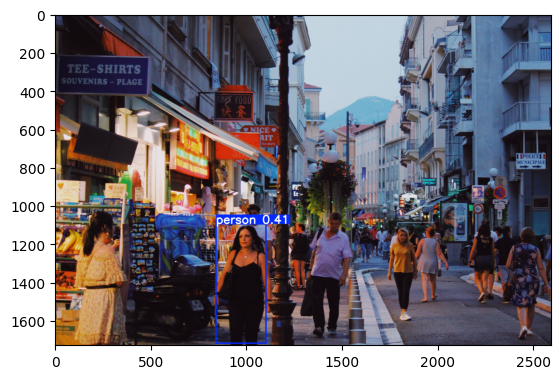

In [48]:
results2 = model2.predict(t)

sh(results2, np.random.randint(low=0, high=len(t)))

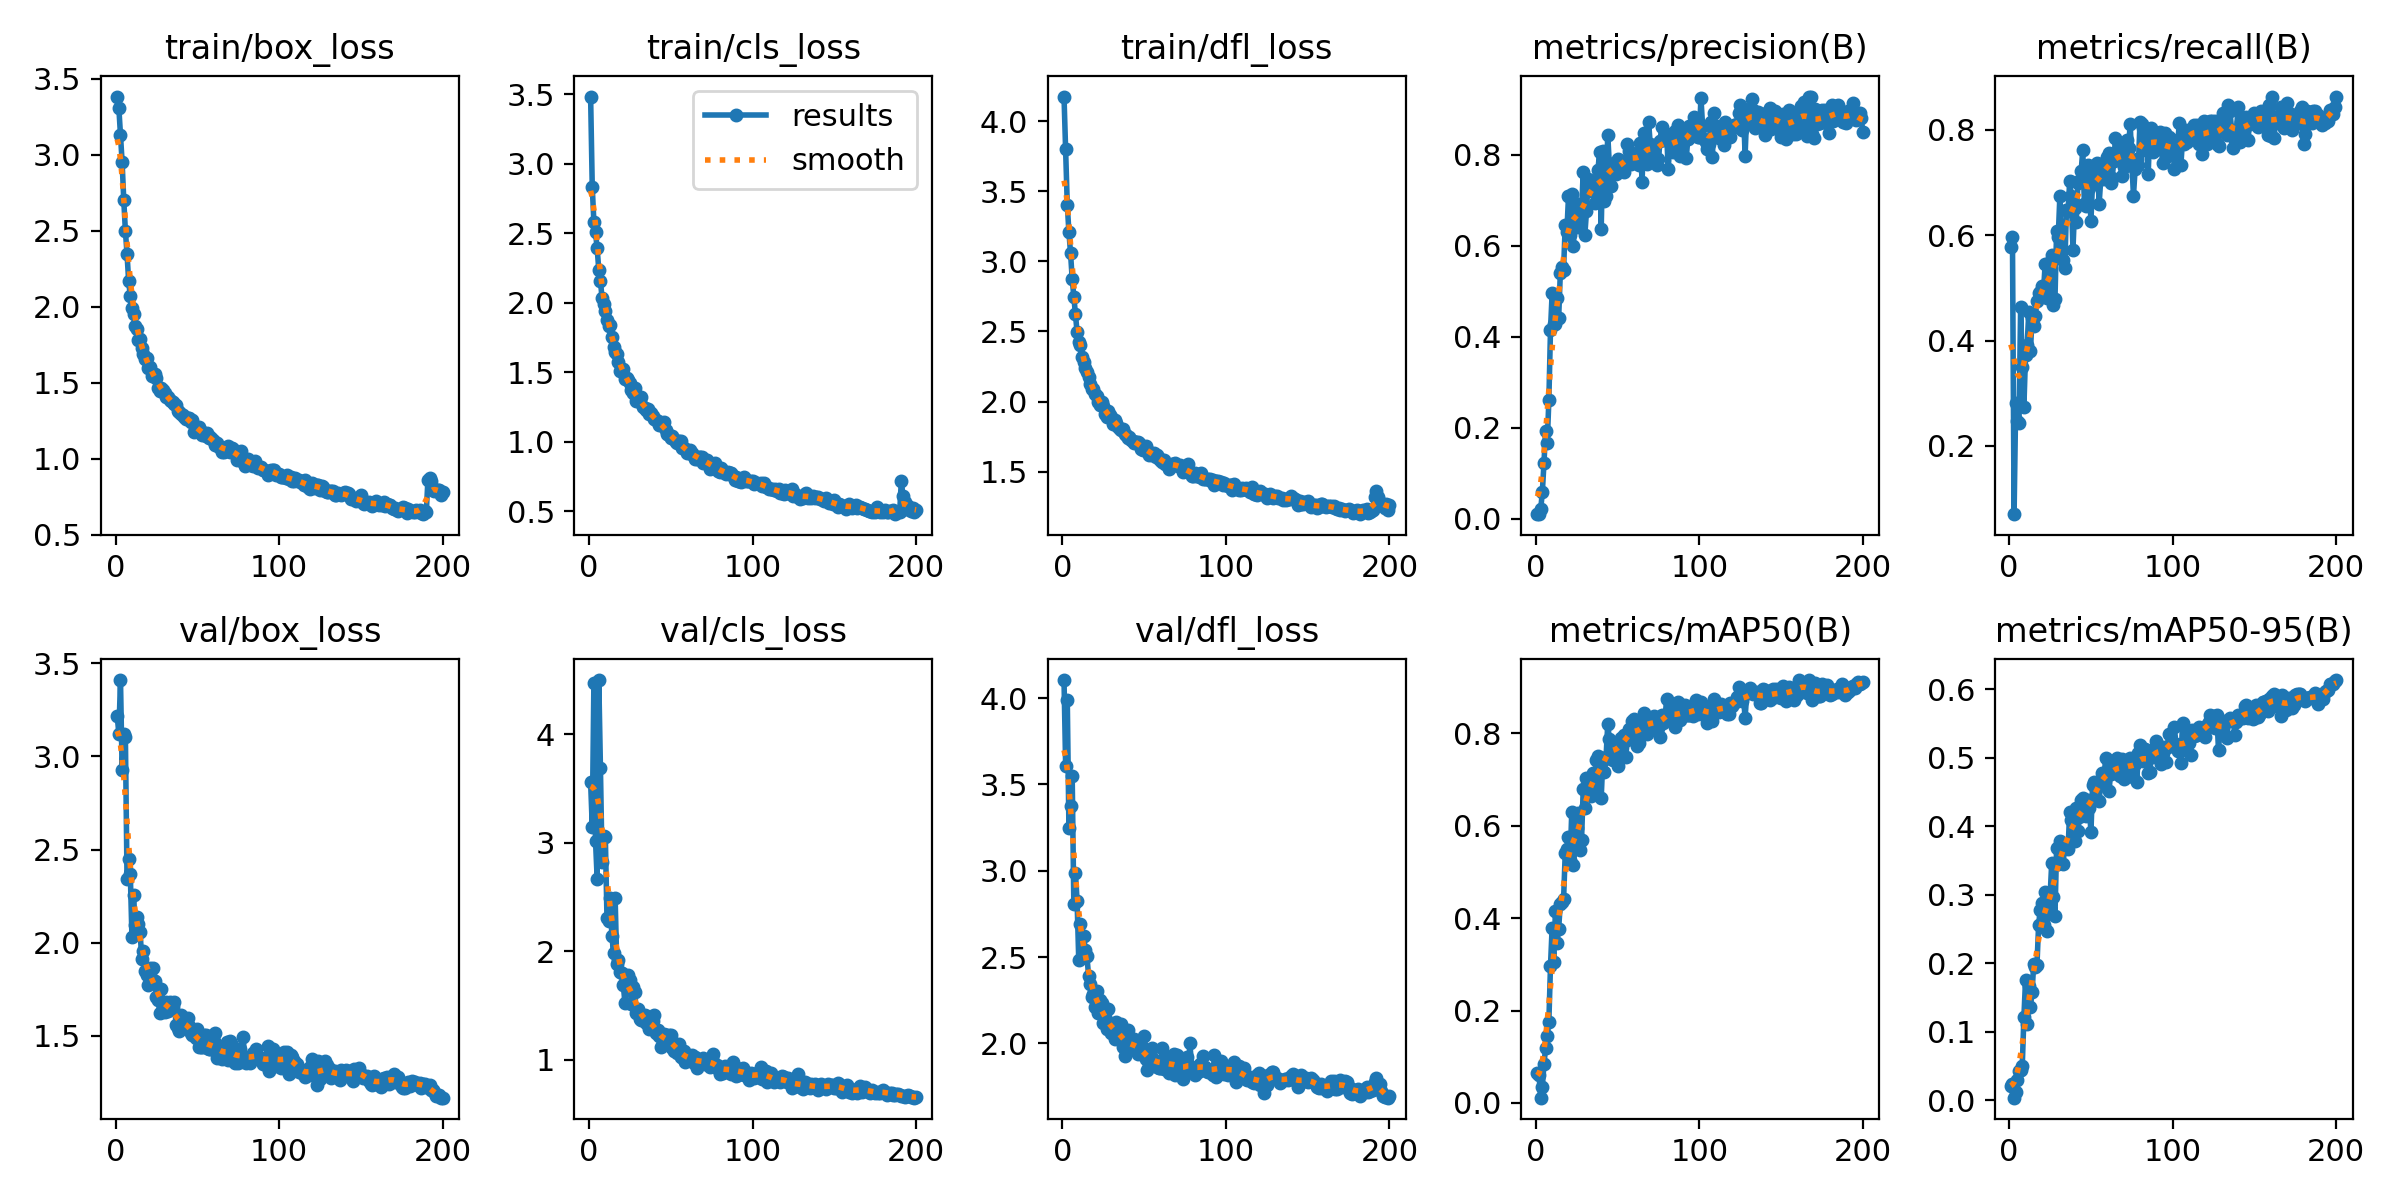

In [49]:
Image(filename='/kaggle/working/runs/detect/train2/results.png', width=1100, height=550)

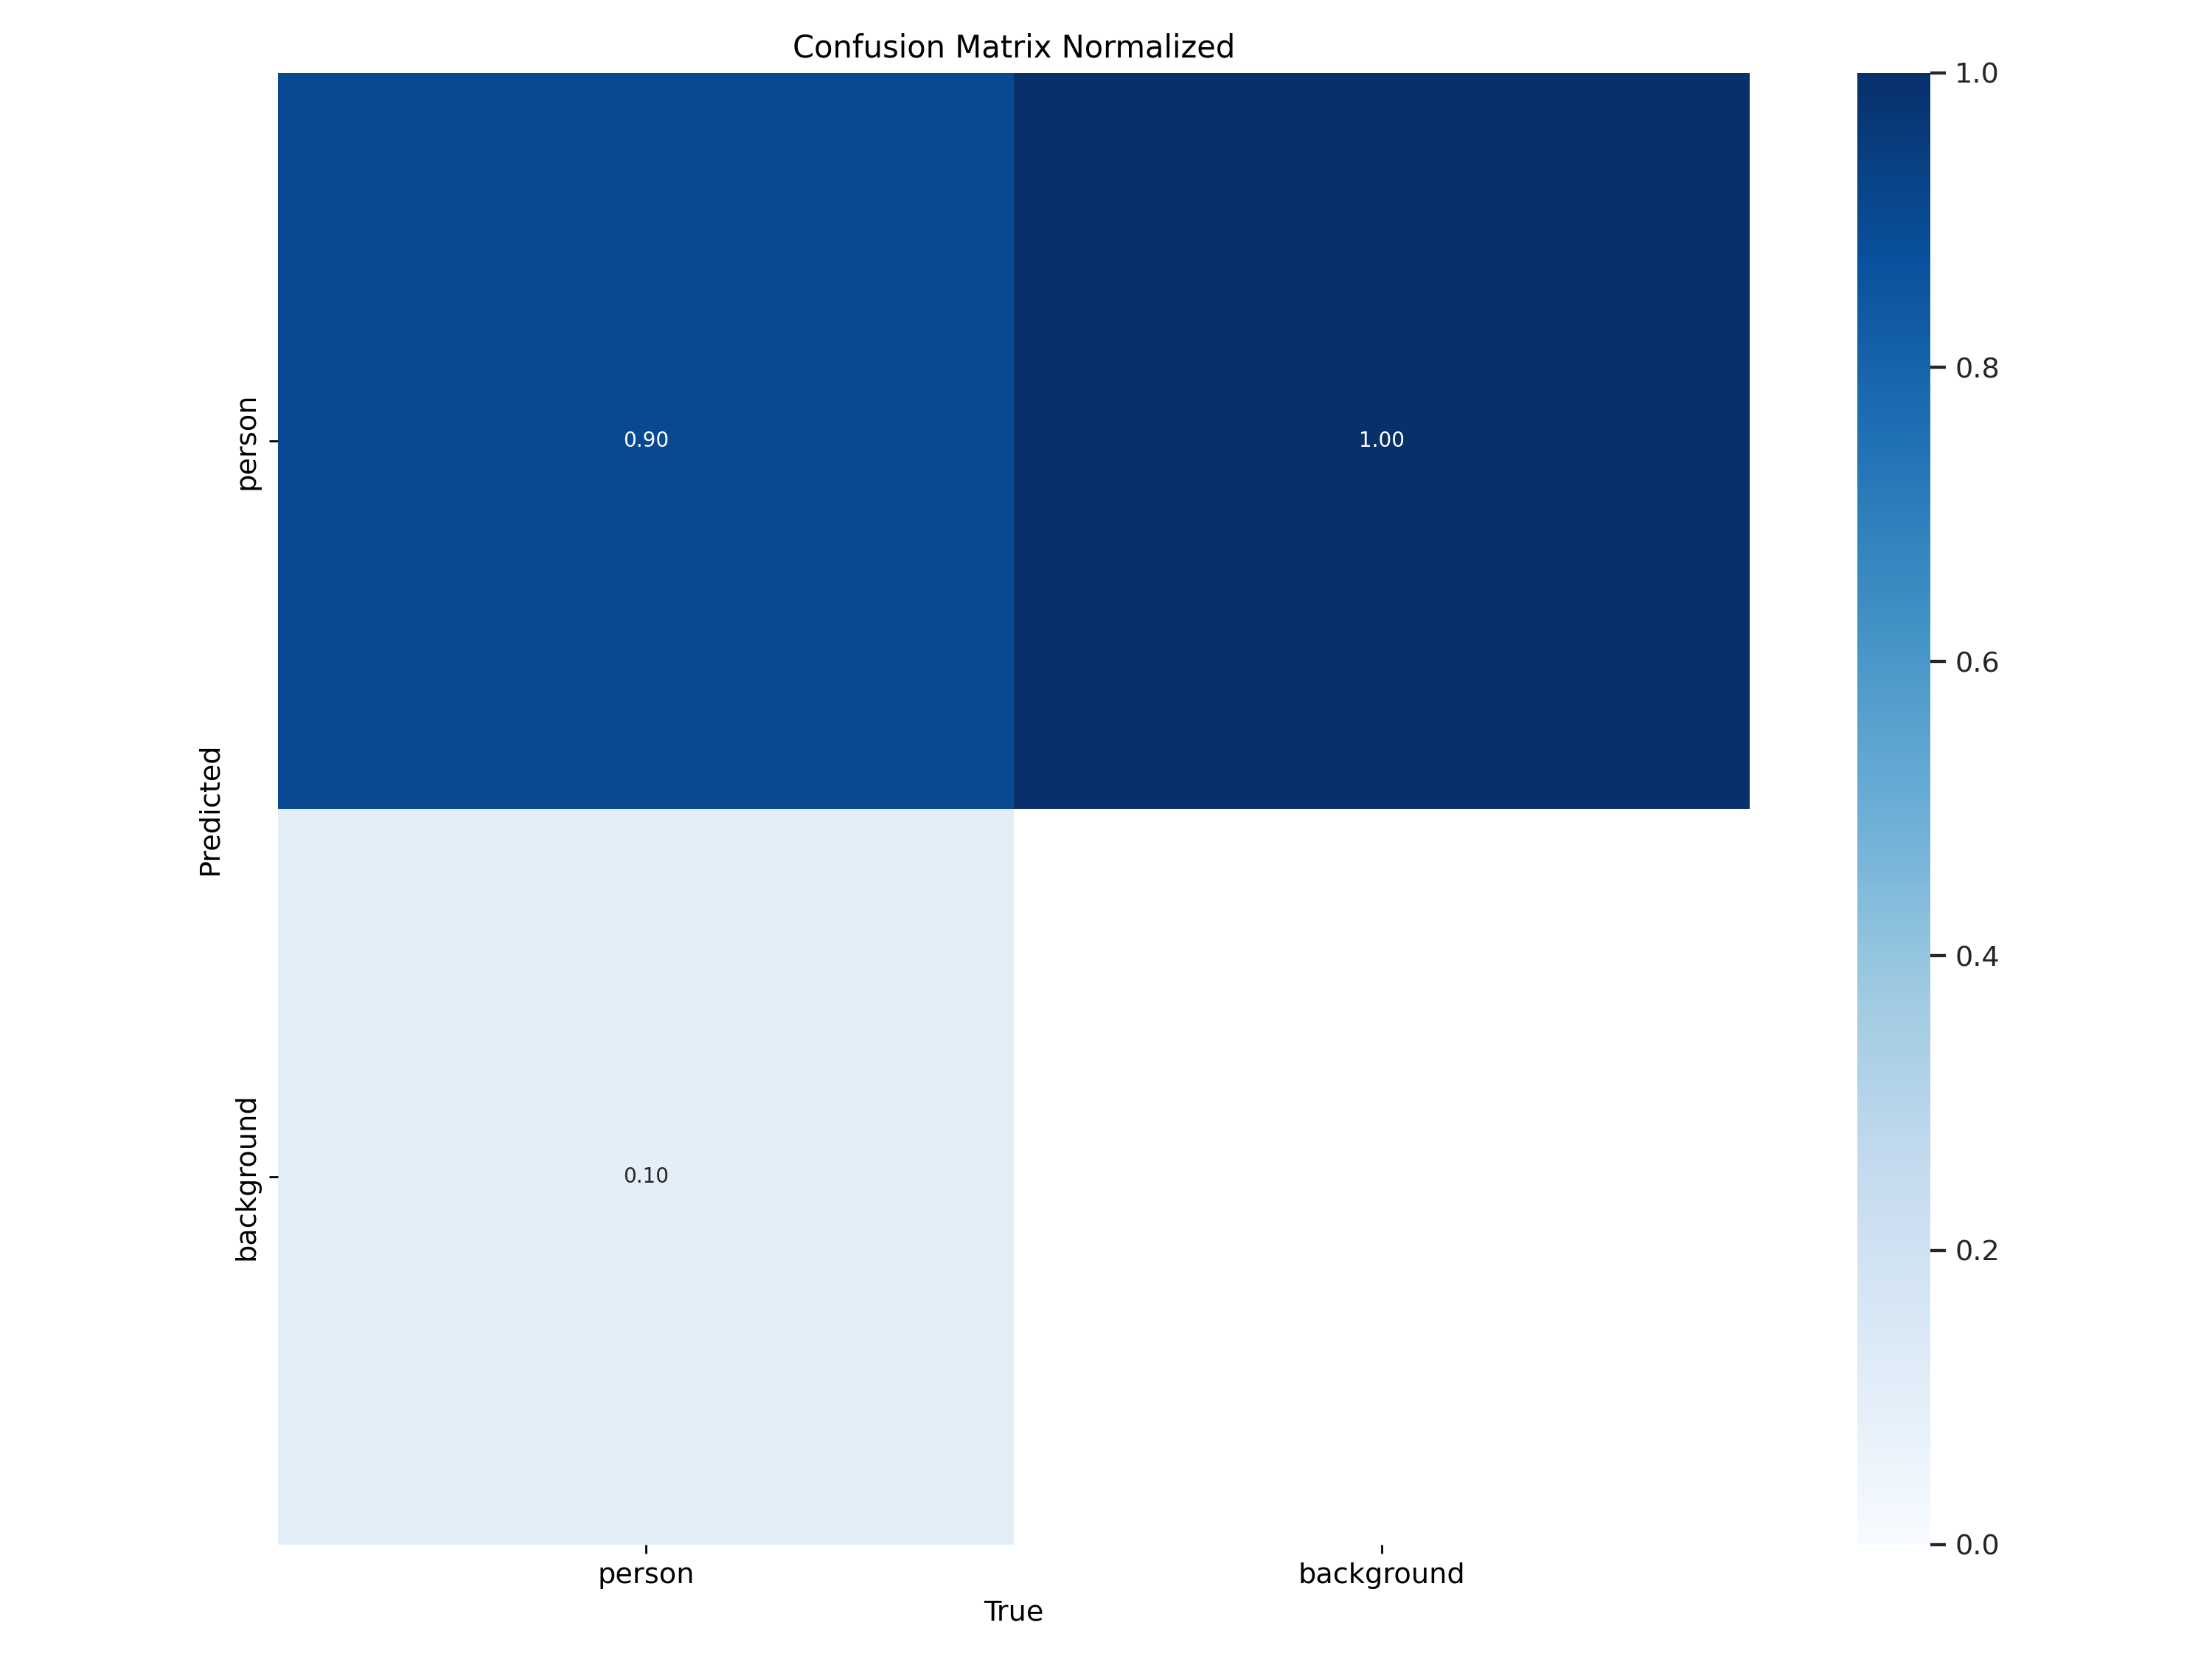

In [50]:
Image(filename='/kaggle/working/runs/detect/train2/confusion_matrix_normalized.png', width=1100, height=550)